In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, ListedColormap
import matplotlib.colorbar as colorbar
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Slider
import matplotlib.animation as animation
import matplotlib as mat
import os
import os.path as op
from scipy.stats import gaussian_kde
from matplotlib import font_manager as fm
# import seaborn as sea
# import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from scipy.stats import rayleigh, norm
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KernelDensity
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.signal import savgol_filter
from peregrin.scripts import PlotParams, FilesAndFolders

In [2]:
# input file path:
# input_file1 = r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\C2-position_spots1.csv"
# input_file2 = r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\C2-position_spots2.csv"
# input_file3 = r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\C2-position_spots3.csv"

input_file1 = r"C:\Users\modri\Desktop\lab\runs from the same experiment\C2-position_spots1.csv"
input_file2 = r"C:\Users\modri\Desktop\lab\runs from the same experiment\C2-position_spots2.csv"
input_file3 = r"C:\Users\modri\Desktop\lab\runs from the same experiment\C2-position_spots3.csv"

# input_file2 = pd.DataFrame().empty
# input_file3 = pd.DataFrame().empty

In [3]:
input_files = [input_file1, input_file2, input_file3]

input_filesA = [input_file1, input_file2]
input_filesB = [input_file2, input_file3]
input_filesC = [input_file1, input_file3]

parsed_input = [input_filesA, input_filesB, input_filesC]
# input_files = [input_file1]

In [4]:
# ===========================================================================================================================================================================================================================================================================	
# Optics parameters

# Definition of micron length per pixel
microns_per_pixel = 0.7381885238402274 # for 10x lens

# Define the desired dimensions in microns
x_min, x_max = 0, (1600 * microns_per_pixel)
y_min, y_max = 0, (1200 * microns_per_pixel)
x_axe_remainder = x_max-1150
x_add = 50 - x_axe_remainder
y_ax_remainder = y_max-850
x_substract = (x_max - y_max) + (y_ax_remainder - 50)

# Calculate the aspect ratio
aspect_ratio = x_max / y_max



# ===========================================================================================================================================================================================================================================================================
# Globally used callables

# plot specs
title_size = 16
title_size2 = 12
label_size = 11
figtext_size = 9
compass_annotations_size = 15
figtext_color = 'grey'

# Color maps
cmap_cells = mcolors.LinearSegmentedColormap.from_list("", ["#9b598910", "#9b181eff"])
cmap_frames = plt.get_cmap('viridis')


In [5]:
def try_convert_numeric(x):
    try:
        # Only process strings
        if isinstance(x, str):
            x_stripped = x.strip()
            num = float(x_stripped)
            if num.is_integer():
                return int(num)
            else:
                return num
        else:
            return x
    except ValueError:
        return x

In [6]:
def merge_dfs(dataframes, on):

    # Initialize the first DataFrame as the base for merging
    merged_df = dataframes[0].map(str)

    # Use a for loop to merge each subsequent DataFrame
    for df in dataframes[1:]:

        df = df.reset_index(drop=True)
        df = df.map(str)
        merge_columns = [col for col in df.columns if col not in merged_df.columns or col in on]
        merged_df = pd.merge(
            merged_df,
            df[merge_columns],  # Select only necessary columns from df
            on=on,
            how='outer'
        )
    
    merged_df = merged_df.map(try_convert_numeric)
    return merged_df

In [7]:
def butter(df):                                                                                      # Smoothing the raw dataframe

    float_columns = [ # Definition of unneccesary float columns in the df which are to be convertet to integers
    'ID', 
    'TRACK_ID', 
    'POSITION_T', 
    'FRAME'
    ]

    df = pd.DataFrame(df)  
    df = df.apply(pd.to_numeric, errors='coerce').dropna(subset=['POSITION_X', 'POSITION_Y', 'POSITION_T'])                                 # Gets rid of the multiple index rows by converting the values to a numeric type and then dropping the NaN values

    # For some reason, the y coordinates extracted from trackmate are mirrored. That ofcourse would not affect the statistical tests, only the data visualization. However, to not get mindfucked..
    # Reflect y-coordinates around the midpoint for the directionality to be accurate, according to the microscope videos.
    y_mid = (df['POSITION_Y'].min() + df['POSITION_Y'].max()) / 2
    df['POSITION_Y'] = 2 * y_mid - df['POSITION_Y']

    df['POSITION_Y'] = df['POSITION_Y'] * microns_per_pixel
    df['POSITION_X'] = df['POSITION_X'] * microns_per_pixel

    columns_list = df.columns.tolist()
    columns_list.remove('LABEL')

    df = df[columns_list]

    # Here we convert the unnecessary floats (from the list in which we defined them) to integers
    df[float_columns] = df[float_columns].astype(int)

    return df



In [8]:
def parsed_file(input_files):  # File-reading
    # =============================================================================================================================================================================================================================================================================
    # Processing the default input files

    if input_files is None:
        return pd.DataFrame()

    all_data_dflt = []
    for list_count, sublist in enumerate(input_files, start=1):  # Enumerate and cycle through input lists
        condition = list_count  # Assign a unique condition number for each list
        for file_count, file_dflt in enumerate(sublist, start=1):  # Enumerate and cycle through files in the sublist
            df_dflt = pd.read_csv(file_dflt)
            buttered_dflt = butter(df_dflt)  # Process the DataFrame

            buttered_dflt['CONDITION'] = condition  # Assign the condition number
            buttered_dflt['REPLICATE'] = file_count  # Assign the replicate number

            all_data_dflt.append(buttered_dflt)  # Store processed DataFrame

    default = pd.concat(all_data_dflt, axis=0)  # Join the DataFrames
    return default

# Example usage
buttered = parsed_file(parsed_input)  # Displayed data is the processed DataFram
# display(cic)


In [9]:
'''
def parsed_file(input_files):                              # File-reading 
        
    # =============================================================================================================================================================================================================================================================================
    # Processing the default input files

                    
    inpt_file_list_dflt = input_files                                               # Getting the list of default input files

    if inpt_file_list_dflt is None:
        default = pd.DataFrame()

    else:
        all_data_dflt = []
        for file_count, file_dflt in enumerate(inpt_file_list_dflt, start=1):       # Enumerate and cycle through default input files
            df_dflt = pd.read_csv(file_dflt)                     
            buttered_dflt = butter(df_dflt)                                      # Process the DataFrame


                                                                
            label_dflt = 'file'                                            # Getting the label to assign the 'CONDITION' column parameter
            buttered_dflt['CONDITION'] = f"{label_dflt}"
            buttered_dflt['REPLICATE'] = f"{file_count}"                            # Assign the 'FILE' column parameter

            buttered_dflt = buttered_dflt                         # Drop duplicates
            all_data_dflt += [buttered_dflt]                                        # Store processed DataFrame

            default = pd.concat(all_data_dflt, axis=0)                              # Join the DataFrames

    return default

display(parsed_file(input_files)) # Displayed data is the processed DataFrame
'''


'\ndef parsed_file(input_files):                              # File-reading \n        \n    # =============================================================================================================================================================================================================================================================================\n    # Processing the default input files\n\n                    \n    inpt_file_list_dflt = input_files                                               # Getting the list of default input files\n\n    if inpt_file_list_dflt is None:\n        default = pd.DataFrame()\n\n    else:\n        all_data_dflt = []\n        for file_count, file_dflt in enumerate(inpt_file_list_dflt, start=1):       # Enumerate and cycle through default input files\n            df_dflt = pd.read_csv(file_dflt)                     \n            buttered_dflt = butter(df_dflt)                                      # Process the DataFrame\n\n\n               

In [10]:
def try_convert_numeric(x):
    try:
        # Only process strings
        if isinstance(x, str):
            x_stripped = x.strip()
            num = float(x_stripped)
            if num.is_integer():
                return int(num)
            else:
                return num
        else:
            return x
    except ValueError:
        return x

In [11]:
# buttered = parsed_file(input_files)
# display(buttered)

In [12]:

def calculate_traveled_distances_for_each_cell_per_frame(df):

    if df.empty:
        return np.nan

    # Ensure the DataFrame is sorted properly by CONDITION, TRACK_ID, and POSITION_T (time)
    df_sorted = df.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])

    # For each track (within each condition), shift the coordinates to get the "next" point
    next_POSITION_X = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['POSITION_X'].shift(-1)
    next_POSITION_Y = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['POSITION_Y'].shift(-1)
    # df_sorted['next_POSITION_Z'] = df_sorted.groupby(['CONDITION', 'TRACK_ID'])['POSITION_Z'].shift(-1)

    # Calculate the Euclidean distance for the XY plane between consecutive points
    df_sorted['DISTANCE'] = np.sqrt(
        (next_POSITION_X - df_sorted['POSITION_X'])**2 +
        (next_POSITION_Y - df_sorted['POSITION_Y'])**2
    )

    # Optionally, drop rows where the next value is missing (i.e. the last row per track)
    df_sorted['DISTANCE'] = df_sorted['DISTANCE'].fillna(0)
    df_result = df_sorted

    # Display the results
    return df_result



display(calculate_traveled_distances_for_each_cell_per_frame(buttered))



ID  TRACK_ID   QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
59      78691         0  1.917663  734.405241  159.708518         0.0   
215     78696         1  1.938016  667.196865  148.348377         0.0   
359     78697         3  1.995014  494.272196  142.511364         0.0   
508     78699         4  2.663755   60.637322  137.039638         0.0   
652     78701         5  2.342726  176.407243  134.859459         0.0   
...       ...       ...       ...         ...         ...         ...   
14919  244143       618  1.336532  469.887837  234.087753         0.0   
14949  244082       622  2.203650  484.166955  383.863573         0.0   
14968  244176       646  1.059941  275.892554  152.424451         0.0   
14982  244041       659  1.986115  737.522160  479.954478         0.0   
15006  244017       669  2.868753  551.727675  560.078580         0.0   

       POSITION_T  FRAME  RADIUS  VISIBILITY  ...  MAX_INTENSITY_CH1  \
59              0      0     2.5         1.0  ...                9.0   
215             0      0     2.5         1.0  ...                9.0   
359             0      0     2.5         1.0  ...                9.0   
508             0      0     2.5         1.0  ...               12.0   
652             0      0     2.5         1.0  ...               11.0   
...           ...    ...     ...         ...  ...                ...   
14919         149    149     2.5         1.0  ...                6.0   
14949         149    149     2.5         1.0  ...               10.0   
14968         149    149     2.5         1.0  ...                5.0   
14982         149    149     2.5         1.0  ...                9.0   
15006         149    149     2.5         1.0  ...               13.0   

       TOTAL_INTENSITY_CH1  STD_INTENSITY_CH1  EXTRACK_P_STUCK  \
59                   254.0           2.800418              NaN   
215                  248.0           3.281809              NaN   
359                  271.0           2.698292              NaN   
508                  361.0           3.932807              NaN   
652                  305.0           4.316669              NaN   
...                    ...                ...              ...   
14919                188.0           1.831490              NaN   
14949                294.0           3.922485              NaN   
14968                132.0           1.937073              NaN   
14982                261.0           3.072693              NaN   
15006                396.0           3.710831              NaN   

       EXTRACK_P_DIFFUSIVE  CONTRAST_CH1   SNR_CH1  CONDITION  REPLICATE  \
59                     NaN      0.722242  2.056022          1          1   
215                    NaN      0.730721  1.724612          1          1   
359                    NaN      0.768847  2.359708          1          1   
508                    NaN      0.778638  2.172106          1          1   
652                    NaN      0.717273  1.595235          1          1   
...                    ...           ...       ...        ...        ...   
14919                  NaN      0.779821  2.431086          3          2   
14949                  NaN      0.776435  1.770803          3          2   
14968                  NaN      0.723881  1.546735          3          2   
14982                  NaN      0.773700  2.002821          3          2   
15006                  NaN      0.765521  2.501131          3          2   

       DISTANCE  
59     1.840634  
215    1.209361  
359    0.841833  
508    3.130401  
652    0.752148  
...         ...  
14919  0.000000  
14949  0.000000  
14968  0.000000  
14982  0.000000  
15006  0.000000  

[101734 rows x 24 columns]

In [13]:

def calculate_direction_of_travel_for_each_cell_per_frame(df):
    directions = []
    for condition in df['CONDITION'].unique():
        unique_cond = df[df['CONDITION'] == condition]
        for replicate in unique_cond['REPLICATE'].unique():
            unique_rep = unique_cond[unique_cond['REPLICATE'] == replicate]
            for track_id in unique_rep['TRACK_ID'].unique():   
                unique_track = unique_rep[unique_rep['TRACK_ID'] == track_id]
                dx = unique_track['POSITION_X'].diff().iloc[1:]
                dy = unique_track['POSITION_Y'].diff().iloc[1:]
                rad = (np.arctan2(dy, dx))
                for i in range(len(rad)):
                    directions.append({
                        'CONDITION': unique_cond['CONDITION'].iloc[i],
                        'REPLICATE': unique_rep['REPLICATE'].iloc[i],
                        'TRACK_ID': unique_track['TRACK_ID'].iloc[i], 
                        'POSITION_T': unique_track['POSITION_T'].iloc[i], 
                        'DIRECTION_RAD': rad.iloc[i],
                        })
    directions_df = pd.DataFrame(directions)
    return directions_df

display(calculate_direction_of_travel_for_each_cell_per_frame(buttered))


CONDITION  REPLICATE  TRACK_ID  POSITION_T  DIRECTION_RAD
0               1          1         0          85       1.514215
1               1          1         0           1      -1.256274
2               1          1         0          50      -1.945883
3               1          1         0          93       1.582962
4               1          1         0           7      -1.375615
...           ...        ...       ...         ...            ...
100417          3          2       669         135       1.828038
100418          3          2       669         134      -1.425180
100419          3          2       669         138      -2.182896
100420          3          2       669         142       0.394099
100421          3          2       669         139      -2.870165

[100422 rows x 5 columns]

In [ ]:
distances_for_each_cell_per_frame_df = calculate_traveled_distances_for_each_cell_per_frame(buttered)        # Call the function to calculate distances for each cell per frame and create the Spot_statistics .csv file
direction_for_each_cell_per_frame_df = calculate_direction_of_travel_for_each_cell_per_frame(buttered)       # Call the function to calculate direction_for_each_cell_per_frame_df

Spot_stats_dfs = [buttered, distances_for_each_cell_per_frame_df, direction_for_each_cell_per_frame_df]

Spot_stats = merge_dfs(Spot_stats_dfs, on=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T']) # Merge the dataframes
Spot_stats = Spot_stats.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])	
display(Spot_stats)
	


d_types = Spot_stats.map(type)
print(d_types)

ID  TRACK_ID   QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
0        78691         0  1.917663  734.405241  159.708518           0   
150      78696         1  1.938016  667.196865  148.348377           0   
293      78613       101  3.599400  561.040267  434.672634           0   
443      78615       102  2.291106  239.616232  425.659059           0   
588      78616       103  1.749224  333.587900  423.694683           0   
...        ...       ...       ...         ...         ...         ...   
100634  244104        76  1.883304  362.761055  317.060643           0   
100902  244110        79  1.368314  190.186689  310.588812           0   
101321  244151        89  1.260353  112.214516  216.577757           0   
101494  244138        98  1.319224  385.002672  246.849952           0   
101640  244137        99  2.425156  257.128890  246.613265           0   

        POSITION_T  FRAME  RADIUS  VISIBILITY  ...  TOTAL_INTENSITY_CH1  \
0                0      0     2.5           1  ...                  254   
150              0      0     2.5           1  ...                  248   
293              0      0     2.5           1  ...                  479   
443              0      0     2.5           1  ...                  293   
588              0      0     2.5           1  ...                  244   
...            ...    ...     ...         ...  ...                  ...   
100634         149    149     2.5           1  ...                  242   
100902         149    149     2.5           1  ...                  177   
101321         149    149     2.5           1  ...                  180   
101494         149    149     2.5           1  ...                  184   
101640         149    149     2.5           1  ...                  328   

        STD_INTENSITY_CH1  EXTRACK_P_STUCK  EXTRACK_P_DIFFUSIVE  CONTRAST_CH1  \
0                2.800418              NaN                  NaN      0.722242   
150              3.281809              NaN                  NaN      0.730721   
293              6.297909              NaN                  NaN      0.707882   
443              3.861335              NaN                  NaN      0.677675   
588              2.554511              NaN                  NaN      0.749821   
...                   ...              ...                  ...           ...   
100634           3.158715              NaN                  NaN      0.683729   
100902           2.800150              NaN                  NaN      0.595108   
101321           1.945967              NaN                  NaN      0.711085   
101494           1.833129              NaN                  NaN      0.766562   
101640           3.309600              NaN                  NaN      0.771605   

         SNR_CH1  CONDITION  REPLICATE  DISTANCE  DIRECTION_RAD  
0       2.056022          1          1  1.840634      -1.242524  
150     1.724612          1          1  1.209361      -1.254568  
293     1.704004          1          1  0.249880       1.571786  
443     1.656808          1          1  1.179649       2.408845  
588     2.212454          1          1  5.924729       2.843261  
...          ...        ...        ...       ...            ...  
100634  1.681687          3          2  0.000000      -2.320406  
100902  1.274752          3          2  0.000000      -1.682220  
101321  2.077855          3          2  0.000000       2.296600  
101494  2.354352          3          2  0.000000      -2.741262  
101640  2.333215          3          2  0.000000       1.262560  

[101734 rows x 25 columns]

                   ID       TRACK_ID          QUALITY       POSITION_X  \
0       <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
150     <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
293     <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
443     <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
588     <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
...               ...            ...              ...              ...   
100634  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
100902  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
101321  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
101494  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
101640  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   

             POSITION_Y     POSITION_Z     POSITION_T          FRAME  \
0       <class 'float'>  <class 'int'> 

In [15]:
def calculate_track_lengths_and_net_distances(df):
    if df.empty:
        return np.nan

    # Ensure the data is sorted
    df_sorted = df.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'FRAME'])
    
    # Sum the DISTANCE values for each track within each condition
    track_length_df = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'], as_index=False)['DISTANCE'].sum().rename(columns={'DISTANCE': 'TRACK_LENGTH'})

    # Calculate the net distance for each track
    def net_distance_per_track(track_df):
        start_position = track_df.iloc[0][['POSITION_X', 'POSITION_Y']].values
        end_position = track_df.iloc[-1][['POSITION_X', 'POSITION_Y']].values
        return np.sqrt((end_position[0] - start_position[0])**2 + (end_position[1] - start_position[1])**2)
    
    net_distances = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID']).apply(net_distance_per_track).reset_index(name='NET_DISTANCE')

    # Merge the track lengths and net distances
    track_lengths_and_net_distances_df = pd.merge(track_length_df, net_distances, on=['CONDITION', 'REPLICATE', 'TRACK_ID'], how='outer')

    return track_lengths_and_net_distances_df

track_data = calculate_track_lengths_and_net_distances(Spot_stats)
display(track_data)


C:\Users\modri\AppData\Local\Temp\ipykernel_31652\1187341206.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  net_distances = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID']).apply(net_distance_per_track).reset_index(name='NET_DISTANCE')


CONDITION  REPLICATE  TRACK_ID  TRACK_LENGTH  NET_DISTANCE
0             1          1         0    190.540029     24.331570
1             1          1         1    239.386674     22.958469
2             1          1         3    226.947239     13.208317
3             1          1         4    344.089392     54.302333
4             1          1         5    215.872367     35.664108
...         ...        ...       ...           ...           ...
1307          3          2       618     73.657862     16.782997
1308          3          2       622     70.870330     22.088006
1309          3          2       646     34.163774     15.548371
1310          3          2       659     27.828403     10.913969
1311          3          2       669     44.177106     21.088621

[1312 rows x 5 columns]

In [16]:

def calculate_confinement_ratio_for_each_cell(df):
    # Calculate the confinement ratio
    df['CONFINEMENT_RATIO'] = df['NET_DISTANCE'] / df['TRACK_LENGTH']
    Track_stats_df = df[['CONDITION', 'REPLICATE', 'TRACK_ID', 'CONFINEMENT_RATIO']]
    return pd.DataFrame(Track_stats_df)

display(calculate_confinement_ratio_for_each_cell(track_data))	


CONDITION  REPLICATE  TRACK_ID  CONFINEMENT_RATIO
0             1          1         0           0.127698
1             1          1         1           0.095905
2             1          1         3           0.058200
3             1          1         4           0.157815
4             1          1         5           0.165209
...         ...        ...       ...                ...
1307          3          2       618           0.227851
1308          3          2       622           0.311668
1309          3          2       646           0.455113
1310          3          2       659           0.392188
1311          3          2       669           0.477365

[1312 rows x 4 columns]

In [17]:


def calculate_distances_per_frame(df):
    # df['POSITION_T'] = df['POSITION_T'].astype(int)  # Convert POSITION_T to integers
    min_distance_per_frame = df.groupby(['CONDITION', 'POSITION_T'])['DISTANCE'].min().reset_index()
    min_distance_per_frame.rename(columns={'DISTANCE': 'min_DISTANCE'}, inplace=True)
    max_distance_per_frame = df.groupby(['CONDITION', 'POSITION_T'])['DISTANCE'].max().reset_index()
    max_distance_per_frame.rename(columns={'DISTANCE': 'max_DISTANCE'}, inplace=True)
    mean_distances_per_frame = df.groupby(['CONDITION', 'POSITION_T'])['DISTANCE'].mean().reset_index()
    mean_distances_per_frame.rename(columns={'DISTANCE': 'MEAN_DISTANCE'}, inplace=True)
    std_deviation_distances_per_frame = df.groupby(['CONDITION', 'POSITION_T'])['DISTANCE'].std().reset_index()
    std_deviation_distances_per_frame.rename(columns={'DISTANCE': 'STD_DEVIATION_distances'}, inplace=True)
    median_distances_per_frame = df.groupby(['CONDITION', 'POSITION_T'])['DISTANCE'].median().reset_index()
    median_distances_per_frame.rename(columns={'DISTANCE': 'MEDIAN_DISTANCE'}, inplace=True)

    merging = [min_distance_per_frame, max_distance_per_frame, mean_distances_per_frame, std_deviation_distances_per_frame, median_distances_per_frame]
    merged = merge_dfs(merging, on=['CONDITION', 'POSITION_T'])
    merged = merged.sort_values(by=['CONDITION', 'POSITION_T'])
    return merged

frame_data = calculate_distances_per_frame(Spot_stats)
display(frame_data)




CONDITION  POSITION_T  min_DISTANCE  max_DISTANCE  MEAN_DISTANCE  \
0            1           0      0.068300      8.792824       1.949480   
1            1           1      0.000000     12.284804       1.737470   
62           1           2      0.034151      6.197596       1.846125   
73           1           3      0.055810      5.553160       1.793143   
84           1           4      0.055505      7.707942       1.734746   
..         ...         ...           ...           ...            ...   
352          3         145      0.000000      7.145239       0.905355   
353          3         146      0.000000      5.447057       0.861830   
354          3         147      0.000000      7.302103       0.805473   
355          3         148      0.000000      5.449223       0.842270   
356          3         149      0.000000      0.000000       0.000000   

     STD_DEVIATION_distances  MEDIAN_DISTANCE  
0                   1.516862         1.555708  
1                   1.570339         1.223714  
62                  1.442310         1.496084  
73                  1.238198         1.500695  
84                  1.317136         1.330836  
..                       ...              ...  
352                 1.142892         0.471785  
353                 1.035747         0.407562  
354                 1.142792         0.359285  
355                 1.066526         0.389399  
356                 0.000000         0.000000  

[450 rows x 7 columns]

In [18]:

def weighted_mean_direction(angles, weights):
    weighted_sin = np.average(np.sin(angles), weights=weights)
    weighted_cos = np.average(np.cos(angles), weights=weights)
    return np.arctan2(weighted_sin, weighted_cos)


In [19]:
def weighted_std_deviation(angles, weights, mean_direction_rad):
    weighted_sin = np.average(np.sin(angles - mean_direction_rad), weights=weights)
    weighted_cos = np.average(np.cos(angles - mean_direction_rad), weights=weights)
    return np.sqrt(weighted_sin**2 + weighted_cos**2)

In [20]:
def weighted_median_direction(angles, weights):
    sorted_angles = np.sort(angles)
    sorted_weights = np.array(weights)[np.argsort(angles)]
    cumsum_weights = np.cumsum(sorted_weights)
    midpoint = np.sum(weights) / 2
    idx = np.searchsorted(cumsum_weights, midpoint)
    return sorted_angles[idx]

In [21]:
def calculate_absolute_directions_per_cell(df):
    mean_direction_rad = df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles))))
    mean_direction_deg = np.degrees(mean_direction_rad) % 360
    std_deviation_rad = df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['DIRECTION_RAD'].apply(lambda angles: np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2))
    std_deviation_deg = np.degrees(std_deviation_rad) % 360
    median_direction_rad = df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.median(np.sin(angles)), np.median(np.cos(angles))))
    median_direction_deg = np.degrees(median_direction_rad) % 360

    return pd.DataFrame({
        'CONDITION': mean_direction_rad.index.get_level_values('CONDITION'),
        'REPLICATE': mean_direction_rad.index.get_level_values('REPLICATE'),
        'TRACK_ID': mean_direction_rad.index.get_level_values('TRACK_ID'),
        'MEAN_DIRECTION_DEG': mean_direction_deg,
        'STD_DEVIATION_DEG': std_deviation_deg,
        'MEDIAN_DIRECTION_DEG': median_direction_deg,
        'MEAN_DIRECTION_RAD': mean_direction_rad,
        'STD_DEVIATION_RAD': std_deviation_rad,
        'MEDIAN_DIRECTION_RAD': median_direction_rad
    }).reset_index(drop=True)

display(calculate_absolute_directions_per_cell(direction_for_each_cell_per_frame_df))


CONDITION  REPLICATE  TRACK_ID  MEAN_DIRECTION_DEG  STD_DEVIATION_DEG  \
0             1          1         0          265.459344           4.464084   
1             1          1         1          191.234122           2.277124   
2             1          1         3          164.838442           0.800060   
3             1          1         4          266.853185           2.322555   
4             1          1         5           49.973030           0.742990   
...         ...        ...       ...                 ...                ...   
1307          3          2       618          339.554164           1.265131   
1308          3          2       622          349.208749           2.481143   
1309          3          2       646          120.400959          11.518184   
1310          3          2       659          150.020577           6.626343   
1311          3          2       669          244.693675          10.105947   

      MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DEVIATION_RAD  \
0               273.551063           -1.650046           0.077913   
1               198.231376           -2.945520           0.039743   
2               168.426723            2.876974           0.013964   
3               259.431669           -1.625719           0.040536   
4                18.641683            0.872194           0.012968   
...                    ...                 ...                ...   
1307             99.697060           -0.356847           0.022081   
1308            284.811209           -0.188343           0.043304   
1309             96.441959            2.101393           0.201030   
1310            149.400572            2.618353           0.115652   
1311            263.567913           -2.012475           0.176382   

      MEDIAN_DIRECTION_RAD  
0                -1.508819  
1                -2.823395  
2                 2.939601  
3                -1.755248  
4                 0.325359  
...                    ...  
1307              1.740042  
1308             -1.312292  
1309              1.683230  
1310              2.607532  
1311             -1.683057  

[1312 rows x 9 columns]

In [22]:
def calculate_weighted_directions_per_cell(df):
    df = df.dropna(subset=['TRACK_ID'])

    confinement_ratio_weighted_mean_direction_rad = df['MEAN_DIRECTION_RAD'] * df['CONFINEMENT_RATIO'] / df['CONFINEMENT_RATIO']
    confinement_ratio_weighted_mean_direction_deg = np.degrees(confinement_ratio_weighted_mean_direction_rad) % 360
    confinement_ratio_weighted_std_deviation_rad = df['STD_DEVIATION_RAD'] * df['CONFINEMENT_RATIO'] / df['CONFINEMENT_RATIO']    
    confinement_ratio_weighted_std_deviation_deg = np.degrees(confinement_ratio_weighted_std_deviation_rad) % 360
    confinement_ratio_weighted_median_direction_rad = df['MEADIAN_DIRECTION_RAD'] * df['CONFINEMENT_RATIO'] / df['CONFINEMENT_RATIO']
    confinement_ratio_weighted_median_direction_deg = np.degrees(confinement_ratio_weighted_median_direction_rad) % 360

    net_distance_weighted_mean_direction_rad = df['MEAN_DIRECTION_RAD'] * df['NET_DISTANCE'] / df['NET_DISTANCE']
    net_distance_weighted_mean_direction_deg = np.degrees(net_distance_weighted_mean_direction_rad) % 360
    net_distance_weighted_std_deviation_rad = df['STD_DEVIATION_RAD'] * df['NET_DISTANCE'] / df['NET_DISTANCE']
    net_distance_weighted_std_deviation_deg = np.degrees(net_distance_weighted_std_deviation_rad) % 360
    net_distance_weighted_median_direction_rad = df['MEADIAN_DIRECTION_RAD'] * df['NET_DISTANCE'] / df['NET_DISTANCE']
    net_distance_weighted_median_direction_deg = np.degrees(net_distance_weighted_median_direction_rad) % 360    

    return pd.DataFrame({
    'CONDITION': df.index.get_level_values('CONDITION'),
    'REPLICATE': df.index.get_level_values('REPLICATE'),
    'TRACK_ID': df.index.get_level_values('TRACK_ID'),
    'MEAN_DIRECTION_DEG_weight_confinement': confinement_ratio_weighted_mean_direction_deg, 
    'STD_DEVIATION_DEG_weight_confinement': confinement_ratio_weighted_std_deviation_deg, 
    'MEDIAN_DIRECTION_DEG_weight_confinement': confinement_ratio_weighted_median_direction_deg, 
    'MEAN_DIRECTION_RAD_weight_confinement': confinement_ratio_weighted_mean_direction_rad, 
    'STD_DEVIATION_RAD_weight_confinement': confinement_ratio_weighted_std_deviation_rad, 
    'MEADIAN_DIRECTION_RAD_weight_confinement': confinement_ratio_weighted_median_direction_rad,
    'MEAN_DIRECTION_DEG_weight_net_dis': net_distance_weighted_mean_direction_deg, 
    'STD_DEVIATION_DEG_weight_net_dis': net_distance_weighted_std_deviation_deg, 
    'MEDIAN_DIRECTION_DEG_weight_net_dis': net_distance_weighted_median_direction_deg, 
    'MEAN_DIRECTION_RAD_weight_net_dis': net_distance_weighted_mean_direction_rad, 
    'STD_DEVIATION_RAD_weight_net_dis': net_distance_weighted_std_deviation_rad, 
    'MEADIAN_DIRECTION_RAD_weight_net_dis': net_distance_weighted_median_direction_rad
    })



In [23]:
def calculate_absolute_directions_per_frame(df):
    grouped = df.groupby(['CONDITION', 'POSITION_T'])
    mean_direction_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles))))
    mean_direction_deg = np.degrees(mean_direction_rad) % 360
    std_deviation_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2))
    std_deviation_deg = np.degrees(std_deviation_rad) % 360
    median_direction_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.median(np.sin(angles)), np.median(np.cos(angles))))
    median_direction_deg = np.degrees(median_direction_rad) % 360
    
    result_df = pd.DataFrame({
        'CONDITION': mean_direction_rad.index.get_level_values('CONDITION'),
        'POSITION_T': mean_direction_rad.index.get_level_values('POSITION_T'),
        'MEAN_DIRECTION_DEG': mean_direction_deg, 
        'STD_DEVIATION_DEG': std_deviation_deg, 
        'MEDIAN_DIRECTION_DEG': median_direction_deg, 
        'MEAN_DIRECTION_RAD': mean_direction_rad, 
        'STD_DEVIATION_RAD': std_deviation_rad, 
        'MEDIAN_DIRECTION_RAD': median_direction_rad
    }).reset_index(drop=True)
    
    return result_df

# Example usage
result = calculate_absolute_directions_per_frame(direction_for_each_cell_per_frame_df)
display(result)

CONDITION  POSITION_T  MEAN_DIRECTION_DEG  STD_DEVIATION_DEG  \
0            1           0          111.063007          11.949172   
1            1           1          111.236153          12.056825   
2            1           2          105.892535           9.851703   
3            1           3          114.609377          11.819534   
4            1           4          111.566360          11.069882   
..         ...         ...                 ...                ...   
445          3         145           42.458093           7.813503   
446          3         146           78.647586           2.516545   
447          3         147           31.108389           3.843518   
448          3         148           13.119615           4.805787   
449          3         149           37.322577           1.785001   

     MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DEVIATION_RAD  \
0               96.094195            1.938415           0.208552   
1              108.640347            1.941437           0.210431   
2              112.162605            1.848173           0.171945   
3              103.373786            2.000311           0.206290   
4              100.361270            1.947200           0.193206   
..                    ...                 ...                ...   
445             65.787424            0.741034           0.136371   
446            113.167849            1.372659           0.043922   
447             88.813795            0.542944           0.067082   
448              0.000000            0.228980           0.083877   
449            351.913312            0.651402           0.031154   

     MEDIAN_DIRECTION_RAD  
0                1.677160  
1                1.896132  
2                1.957607  
3                1.804213  
4                1.751635  
..                    ...  
445              1.148207  
446              1.975152  
447              1.550093  
448              0.000000  
449             -0.141139  

[450 rows x 8 columns]

In [ ]:
def calculate_weighted_directions_per_frame(df):
    grouped = df.groupby(['CONDITION', 'POSITION_T'])
    
    # Compute weighted metrics
    weighted_mean_direction_rad = grouped.apply(lambda x: weighted_mean_direction(x['DIRECTION_RAD'], x['DISTANCE'])).reset_index(level=0, drop=True)
    weighted_mean_direction_deg = np.degrees(weighted_mean_direction_rad) % 360
    
    weighted_std_deviation_rad = grouped.apply(lambda x: weighted_std_deviation(x['DIRECTION_RAD'], x['DISTANCE'], weighted_mean_direction(x['DIRECTION_RAD'], x['DISTANCE']))).reset_index(level=0, drop=True)
    weighted_std_deviation_deg = np.degrees(weighted_std_deviation_rad) % 360
    
    weighted_median_direction_rad = grouped.apply(lambda x: weighted_median_direction(x['DIRECTION_RAD'], x['DISTANCE'])).reset_index(level=0, drop=True)
    weighted_median_direction_deg = np.degrees(weighted_median_direction_rad) % 360
    
    result_df = pd.DataFrame({
        'CONDITION': grouped['CONDITION'].first().values,
        'POSITION_T': weighted_mean_direction_rad.index,
        'MEAN_DIRECTION_DEG_weight_mean_dis': weighted_mean_direction_deg,
        'STD_DEVIATION_DEG_weight_mean_dis': weighted_std_deviation_deg,
        'MEDIAN_DIRECTION_DEG_weight_mean_dis': weighted_median_direction_deg,
        'MEAN_DIRECTION_RAD_weight_mean_dis': weighted_mean_direction_rad,
        'STD_DEVIATION_RAD_weight_mean_dis': weighted_std_deviation_rad,
        'MEDIAN_DIRECTION_RAD_weight_mean_dis': weighted_median_direction_rad
    }).reset_index(drop=True)
    
    return result_df


In [25]:
def calculate_number_of_frames_per_cell(spot_stats_df):
    # Count the number of frames for each TRACK_ID in the spot_stats_df
    frames_per_track = spot_stats_df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID']).size().reset_index(name='NUM_FRAMES')
    return frames_per_track


In [ ]:
def calculate_speed(df, variable):

    if isinstance(variable, list):
        variable1, variable2 = variable
        min_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].min().reset_index()
        min_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MIN'}, inplace=True)
        max_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].max().reset_index()
        max_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MAX'}, inplace=True)
        mean_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].mean().reset_index()
        mean_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MEAN'}, inplace=True)
        std_deviation_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].std().reset_index()
        std_deviation_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_STD_DEVIATION'}, inplace=True)
        median_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].median().reset_index()
        median_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MEDIAN'}, inplace=True)

        merging = [min_speed_microns_min, max_speed_microns_min, mean_speed_microns_min, std_deviation_speed_microns_min, median_speed_microns_min]
        merged = merge_dfs(merging, on=['CONDITION', variable1, variable2])
        
    else:
        min_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].min().reset_index()
        min_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MIN'}, inplace=True)
        max_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].max().reset_index()
        max_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MAX'}, inplace=True)
        mean_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].mean().reset_index()
        mean_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MEAN'}, inplace=True)
        std_deviation_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].std().reset_index()
        std_deviation_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_STD_DEVIATION'}, inplace=True)
        median_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].median().reset_index()
        median_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MEDIAN'}, inplace=True)
        
        merging = [min_speed_microns_min, max_speed_microns_min, mean_speed_microns_min, std_deviation_speed_microns_min, median_speed_microns_min]
        merged = merge_dfs(merging, on=['CONDITION', variable])

    return pd.DataFrame(merged)

display(Spot_stats)
speed_data = calculate_speed(Spot_stats, 'POSITION_T')
display(speed_data)

ID  TRACK_ID   QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
0        78691         0  1.917663  734.405241  159.708518           0   
150      78696         1  1.938016  667.196865  148.348377           0   
293      78613       101  3.599400  561.040267  434.672634           0   
443      78615       102  2.291106  239.616232  425.659059           0   
588      78616       103  1.749224  333.587900  423.694683           0   
...        ...       ...       ...         ...         ...         ...   
100634  244104        76  1.883304  362.761055  317.060643           0   
100902  244110        79  1.368314  190.186689  310.588812           0   
101321  244151        89  1.260353  112.214516  216.577757           0   
101494  244138        98  1.319224  385.002672  246.849952           0   
101640  244137        99  2.425156  257.128890  246.613265           0   

        POSITION_T  FRAME  RADIUS  VISIBILITY  ...  TOTAL_INTENSITY_CH1  \
0                0      0     2.5           1  ...                  254   
150              0      0     2.5           1  ...                  248   
293              0      0     2.5           1  ...                  479   
443              0      0     2.5           1  ...                  293   
588              0      0     2.5           1  ...                  244   
...            ...    ...     ...         ...  ...                  ...   
100634         149    149     2.5           1  ...                  242   
100902         149    149     2.5           1  ...                  177   
101321         149    149     2.5           1  ...                  180   
101494         149    149     2.5           1  ...                  184   
101640         149    149     2.5           1  ...                  328   

        STD_INTENSITY_CH1  EXTRACK_P_STUCK  EXTRACK_P_DIFFUSIVE  CONTRAST_CH1  \
0                2.800418              NaN                  NaN      0.722242   
150              3.281809              NaN                  NaN      0.730721   
293              6.297909              NaN                  NaN      0.707882   
443              3.861335              NaN                  NaN      0.677675   
588              2.554511              NaN                  NaN      0.749821   
...                   ...              ...                  ...           ...   
100634           3.158715              NaN                  NaN      0.683729   
100902           2.800150              NaN                  NaN      0.595108   
101321           1.945967              NaN                  NaN      0.711085   
101494           1.833129              NaN                  NaN      0.766562   
101640           3.309600              NaN                  NaN      0.771605   

         SNR_CH1  CONDITION  REPLICATE  DISTANCE  DIRECTION_RAD  
0       2.056022          1          1  1.840634      -1.242524  
150     1.724612          1          1  1.209361      -1.254568  
293     1.704004          1          1  0.249880       1.571786  
443     1.656808          1          1  1.179649       2.408845  
588     2.212454          1          1  5.924729       2.843261  
...          ...        ...        ...       ...            ...  
100634  1.681687          3          2  0.000000      -2.320406  
100902  1.274752          3          2  0.000000      -1.682220  
101321  2.077855          3          2  0.000000       2.296600  
101494  2.354352          3          2  0.000000      -2.741262  
101640  2.333215          3          2  0.000000       1.262560  

[101734 rows x 25 columns]

CONDITION  POSITION_T  SPEED_MIN  SPEED_MAX  SPEED_MEAN  \
0            1           0     0.0683   8.792824    1.949480   
1            1           1     0.0000  12.284804    1.737470   
2            1          10     0.0000   6.828995    1.902915   
3            1         100     0.0000   8.173725    1.735487   
4            1         101     0.0000   9.352541    1.847801   
..         ...         ...        ...        ...         ...   
445          3          95     0.0000  14.461565    1.702807   
446          3          96     0.0000   7.990196    1.519456   
447          3          97     0.0000  10.178575    1.678389   
448          3          98     0.0000   6.199037    1.667190   
449          3          99     0.0000  12.928193    1.516547   

     SPEED_STD_DEVIATION  SPEED_MEDIAN  
0               1.516862      1.555708  
1               1.570339      1.223714  
2               1.368084      1.504400  
3               1.498066      1.400058  
4               1.557598      1.409474  
..                   ...           ...  
445             1.622142      1.309342  
446             1.395311      1.141450  
447             1.520661      1.149145  
448             1.324718      1.327765  
449             1.400799      1.254235  

[450 rows x 7 columns]

In [27]:
tracks_lengths_and_net_distances_df = calculate_track_lengths_and_net_distances(Spot_stats) # Calling function to calculate the total distance traveled for each cell from the distances_for_each_cell_per_frame_df
confinement_ratios_df = calculate_confinement_ratio_for_each_cell(tracks_lengths_and_net_distances_df) # Call the function to calculate confinement ratios from the Track_statistics1_df and write it into the Track_statistics1_df
track_directions_df = calculate_absolute_directions_per_cell(Spot_stats) # Call the function to calculate directions_per_cell_df
frames_per_track = calculate_number_of_frames_per_cell(Spot_stats)
speeds_per_cell = calculate_speed(Spot_stats, ['REPLICATE', 'TRACK_ID'])

Track_stats_dfs = [tracks_lengths_and_net_distances_df, confinement_ratios_df, track_directions_df, frames_per_track, speeds_per_cell]
Track_stats = merge_dfs(Track_stats_dfs, on=['CONDITION', 'REPLICATE', 'TRACK_ID'])

Track_stats = Track_stats.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID'])

display(Track_stats)

C:\Users\modri\AppData\Local\Temp\ipykernel_31652\1187341206.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  net_distances = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID']).apply(net_distance_per_track).reset_index(name='NET_DISTANCE')


CONDITION  REPLICATE  TRACK_ID  TRACK_LENGTH  NET_DISTANCE  \
0             1          1         0    190.540029     24.331570   
1             1          1         1    239.386674     22.958469   
87            1          1         3    226.947239     13.208317   
125           1          1         4    344.089392     54.302333   
158           1          1         5    215.872367     35.664108   
...         ...        ...       ...           ...           ...   
1286          3          2       618     73.657862     16.782997   
1288          3          2       622     70.870330     22.088006   
1290          3          2       646     34.163774     15.548371   
1292          3          2       659     27.828403     10.913969   
1293          3          2       669     44.177106     21.088621   

      CONFINEMENT_RATIO  MEAN_DIRECTION_DEG  STD_DEVIATION_DEG  \
0              0.127698          265.459344           4.464084   
1              0.095905          191.234122           2.277124   
87             0.058200          164.838442           0.800060   
125            0.157815          266.853185           2.322555   
158            0.165209           49.973030           0.742990   
...                 ...                 ...                ...   
1286           0.227851          339.554164           1.265131   
1288           0.311668          349.208749           2.481143   
1290           0.455113          120.400959          11.518184   
1292           0.392188          150.020577           6.626343   
1293           0.477365          244.693675          10.105947   

      MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DEVIATION_RAD  \
0                      NaN           -1.650046           0.077913   
1                      NaN           -2.945520           0.039743   
87                     NaN            2.876974           0.013964   
125                    NaN           -1.625719           0.040536   
158                    NaN            0.872194           0.012968   
...                    ...                 ...                ...   
1286                   NaN           -0.356847           0.022081   
1288                   NaN           -0.188343           0.043304   
1290                   NaN            2.101393           0.201030   
1292                   NaN            2.618353           0.115652   
1293                   NaN           -2.012475           0.176382   

      MEDIAN_DIRECTION_RAD  NUM_FRAMES  SPEED_MIN  SPEED_MAX  SPEED_MEAN  \
0                      NaN         150          0   5.112263    1.270267   
1                      NaN         143          0   8.764059    1.674033   
87                     NaN         150          0   5.064273    1.512982   
125                    NaN         140          0  10.178575    2.457781   
158                    NaN         146          0   7.206576    1.478578   
...                    ...         ...        ...        ...         ...   
1286                   NaN          29          0   6.160294    2.539926   
1288                   NaN          26          0   8.849568    2.725782   
1290                   NaN          21          0   4.506373    1.626846   
1292                   NaN          18          0   7.743364    1.546022   
1293                   NaN          19          0   4.873422    2.325111   

      SPEED_STD_DEVIATION  SPEED_MEDIAN  
0                0.989543      1.107627  
1                1.336833      1.547092  
87               1.027985      1.226694  
125              1.921087      2.237195  
158              1.251428      1.047220  
...                   ...           ...  
1286             1.793451      2.365718  
1288             2.381678      1.997512  
1290             1.190566      1.402462  
1292             1.789031      1.135213  
1293             1.571017      1.799906  

[1312 rows x 18 columns]

In [ ]:
distances_per_frame_df = calculate_distances_per_frame(Spot_stats) # Call the function to calculate distances_per_frame_df
absolute_directions_per_frame_df = calculate_absolute_directions_per_frame(Spot_stats) # Call the function to calculate directions_per_frame_df
speeds_per_frame = calculate_speed(Spot_stats, 'POSITION_T') # Call the function to calculate speeds_per_frame

Frame_stats_dfs = [distances_per_frame_df, absolute_directions_per_frame_df, speeds_per_frame]

Frame_stats = merge_dfs(Frame_stats_dfs, on='POSITION_T')
Frame_stats = Frame_stats.merge(Spot_stats['POSITION_T'].drop_duplicates(), on='POSITION_T')

Frame_stats = Frame_stats.sort_values(by=['CONDITION', 'POSITION_T'])

display(Frame_stats)

CONDITION  POSITION_T  min_DISTANCE  max_DISTANCE  MEAN_DISTANCE  \
0             1           0        0.0683      8.792824        1.94948   
1             1           0        0.0683      8.792824        1.94948   
2             1           0        0.0683      8.792824        1.94948   
3             1           0        0.0683      8.792824        1.94948   
4             1           0        0.0683      8.792824        1.94948   
...         ...         ...           ...           ...            ...   
1534          3         149        0.0000      0.000000        0.00000   
1535          3         149        0.0000      0.000000        0.00000   
1536          3         149        0.0000      0.000000        0.00000   
1537          3         149        0.0000      0.000000        0.00000   
1538          3         149        0.0000      0.000000        0.00000   

      STD_DEVIATION_distances  MEDIAN_DISTANCE  MEAN_DIRECTION_DEG  \
0                    1.516862         1.555708          111.063007   
1                    1.516862         1.555708          111.063007   
2                    1.516862         1.555708          111.063007   
3                    1.516862         1.555708          129.450209   
4                    1.516862         1.555708          129.450209   
...                       ...              ...                 ...   
1534                 0.000000         0.000000          319.752654   
1535                 0.000000         0.000000          319.752654   
1536                 0.000000         0.000000           37.322577   
1537                 0.000000         0.000000           37.322577   
1538                 0.000000         0.000000           37.322577   

      STD_DEVIATION_DEG  MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  \
0             11.949172                   NaN            1.938415   
1             11.949172                   NaN            1.938415   
2             11.949172                   NaN            1.938415   
3             11.739828            123.796598            2.259332   
4             11.739828            123.796598            2.259332   
...                 ...                   ...                 ...   
1534           7.689863                   NaN           -0.702449   
1535           7.689863                   NaN           -0.702449   
1536           1.785001                   NaN            0.651402   
1537           1.785001                   NaN            0.651402   
1538           1.785001                   NaN            0.651402   

      STD_DEVIATION_RAD  MEDIAN_DIRECTION_RAD  SPEED_MIN  SPEED_MAX  \
0              0.208552                   NaN   0.068300   8.792824   
1              0.208552                   NaN   0.103193   8.792824   
2              0.208552                   NaN   0.068300   5.972081   
3              0.204899              2.160658   0.068300   8.792824   
4              0.204899              2.160658   0.103193   8.792824   
...                 ...                   ...        ...        ...   
1534           0.134213                   NaN   0.000000   0.000000   
1535           0.134213                   NaN   0.000000   0.000000   
1536           0.031154                   NaN   0.000000   0.000000   
1537           0.031154                   NaN   0.000000   0.000000   
1538           0.031154                   NaN   0.000000   0.000000   

      SPEED_MEAN  SPEED_STD_DEVIATION  SPEED_MEDIAN  
0       1.949480             1.516862      1.555708  
1       1.958169             1.537116      1.655578  
2       1.681483             1.316813      1.263418  
3       1.949480             1.516862      1.555708  
4       1.958169             1.537116      1.655578  
...          ...                  ...           ...  
1534    0.000000             0.000000      0.000000  
1535    0.000000             0.000000      0.000000  
1536    0.000000             0.000000      0.000000  
1537    0.000000             0.000000      0.000000  


In [29]:
def percentile_thresholding(df, column_name: str, values: tuple):
    try:
        lower_percentile, upper_percentile = values
        lower_threshold = np.percentile(df[column_name], lower_percentile)
        upper_threshold = np.percentile(df[column_name], upper_percentile)
        return df[(df[column_name] >= lower_threshold) & (df[column_name] <= upper_threshold)]
    except ValueError:
        return df


In [30]:

def literal_thresholding(df, column_name: str, values: tuple):
    lower_threshold, upper_threshold = values
    return df[(df[column_name] >= lower_threshold) & (df[column_name] <= upper_threshold)]



In [31]:
def dataframe_filter(df, df_filter):
    return df[df["TRACK_ID"].isin(df_filter["TRACK_ID"])]


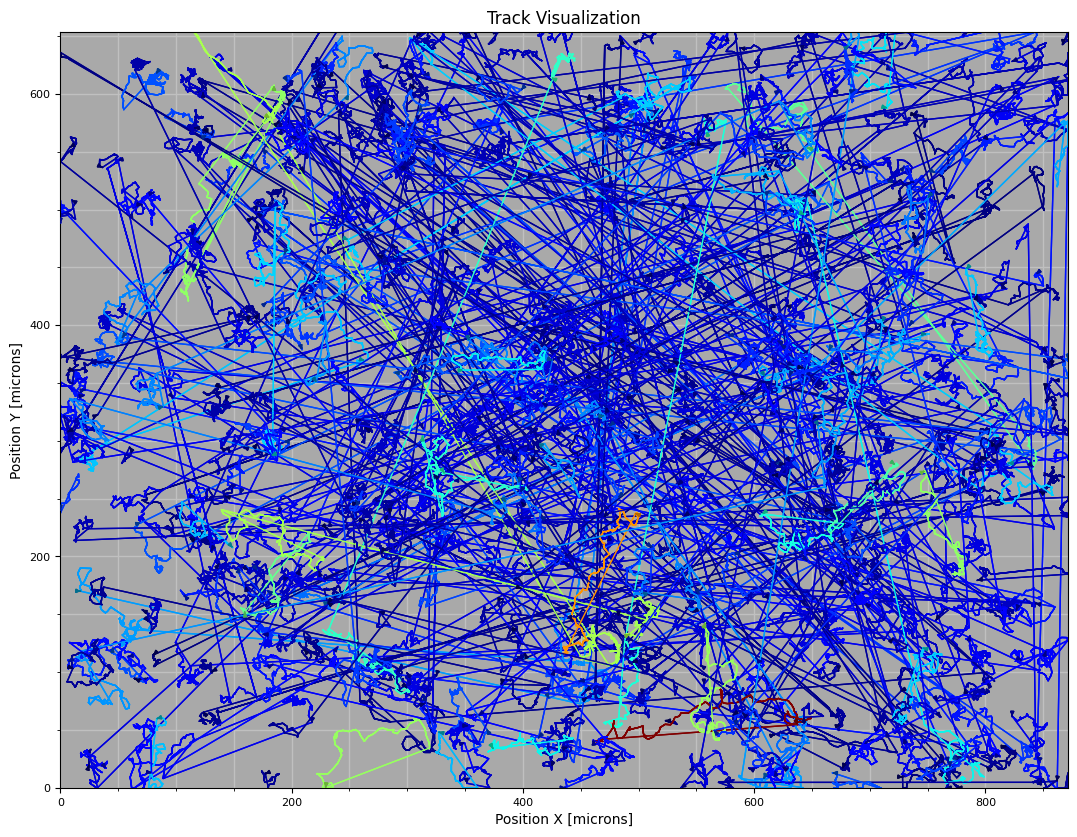

In [32]:

def track_visuals(df, df2, title_size=12):
    # fig and ax definition
    fig, ax = plt.subplots(figsize=(13, 10))

    conditions = df2[['CONDITION', 'REPLICATE']].drop_duplicates()    

    # Filter df2 to only include rows where TRACK_ID is in df's track_ids
    # df_filtered = df[df['TRACK_ID'].isin(track_ids)]

    net_distances = df2[['CONDITION', 'REPLICATE', 'TRACK_ID', 'NET_DISTANCE']]

    # Normalize the NET_DISTANCE to a 0-1 range
    dmin = net_distances['NET_DISTANCE'].min()
    dmax = net_distances['NET_DISTANCE'].max()
    norm = plt.Normalize(vmin=dmin, vmax=dmax)
    colormap = plt.cm.jet

    # Create a dictionary to store the color for each track based on its confinement ratio
    for condition in conditions:
        # Ensuring that dataframse have required data
        track_ids = df2['TRACK_ID'].drop_duplicates()
        track_colors = {}
        for track_id in track_ids:
            ratio = net_distances[net_distances['TRACK_ID'] == track_id]['NET_DISTANCE'].values[0]
            track_colors[track_id] = colormap(norm(ratio))

    # Set up the plot limits
    x_min, x_max = 0.0, 1180.3634496205236*microns_per_pixel
    y_min, y_max = 0.0, 885.0880400844326*microns_per_pixel
    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=title_size)
    ax.set_facecolor('darkgrey')
    ax.grid(True, which='both', axis='both', color='silver', linewidth=1)

    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)

    # Access and modify tick labels
    # for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    #      label.set_fontproperties(roboto_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)

    return fig, ax, conditions, track_ids, track_colors, norm, colormap

def visualize_full_tracks(df, df2, threshold, lw=1):  #Trakcs visualisation

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Using the  track_visuals function
    fig_visuals, ax_visuals, conditions_visuals, track_ids_visuals, track_colors_visuals, norm_visuals, colormap_visuals = track_visuals(df, df2)

    df = df.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])

    # Plot the full tracks
    for condition in conditions_visuals:
        for track_id in track_ids_visuals:
            track_data = df[df['TRACK_ID'] == track_id]
            x = track_data['POSITION_X']
            y = track_data['POSITION_Y']
            ax_visuals.plot(x, y, lw=lw, color=track_colors_visuals[track_id], label=f'Track {track_id}')
            
            # Get the original color from track_colors_visuals[track_id]
            original_color = mcolors.to_rgb(track_colors_visuals[track_id])
            # Darken the color by reducing the brightness (by scaling each RGB channel)
            darkened_color = np.array(original_color) * 0.7  # Adjust 0.7 to a value between 0 and 1 for different darkness levels
            # Ensure that no channel goes below 0 (clip values if necessary)
            darkened_color = np.clip(darkened_color, 0, 1)
            # Apply the darkened color with a slight increase in the green and blue channels for the original factor you had (optional)
            color = darkened_color * np.array([1.0, 1.0, 0.8])  # If you want to keep the original adjustment
        

            if len(x) > 1:
                # Add arrow to indicate direction
                dx = x.diff().iloc[-1]
                dy = y.diff().iloc[-1]
                if dx != 0 or dy != 0:
                    # Create an arrow instead of a circle
                    arrow = FancyArrowPatch(
                        posA=(x.iloc[-2], y.iloc[-2]),  # Start position (second-to-last point)
                        posB=(x.iloc[-1], y.iloc[-1]),  # End position (last point)
                        arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                        color=color,  # Set the color of the arrow
                        mutation_scale=5,  # Scale the size of the arrow head (adjust this based on the plot scale)
                        linewidth=1.2,  # Line width for the arrow
                        zorder=10  # Ensure the arrow is drawn on top of the line
                    )

                    # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
                    plt.gca().add_patch(arrow)

    # plt.savefig(f'01a_Full_tracks_snapshot{threshold}.png', dpi=300)
    # plt.figure()
    return plt.gcf()

plt.show(visualize_full_tracks(Spot_stats, track_data, None, lw=1))

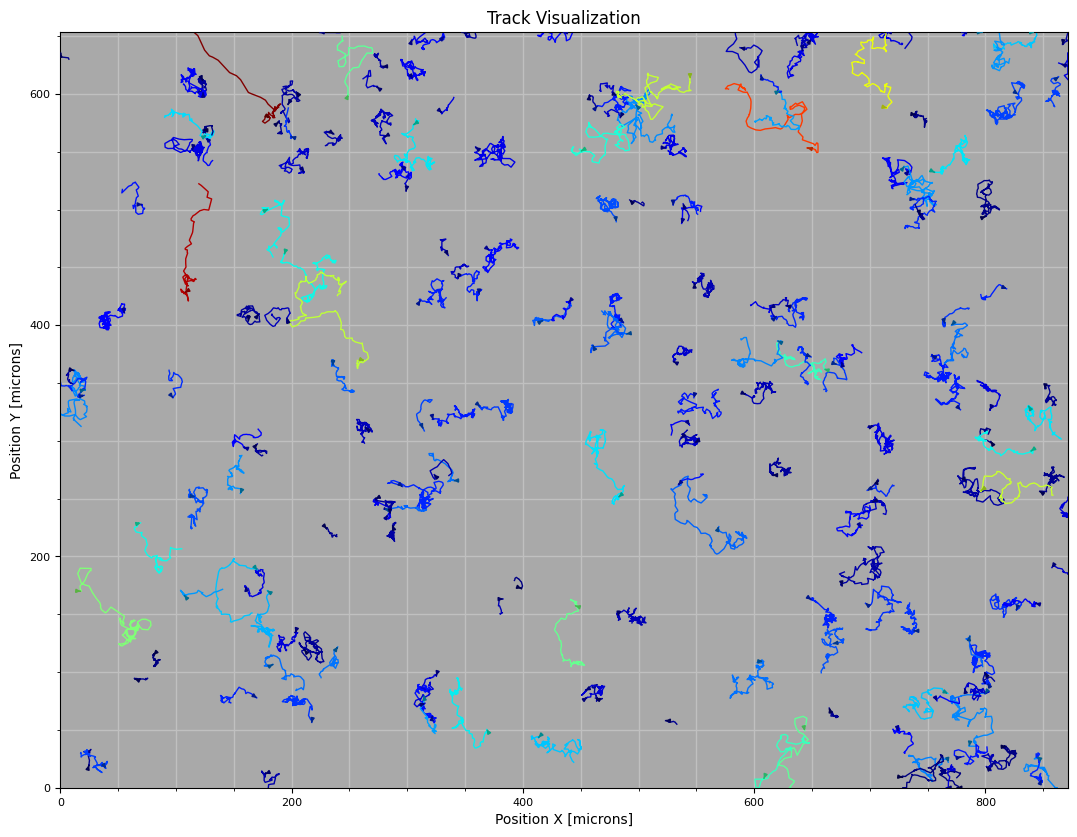

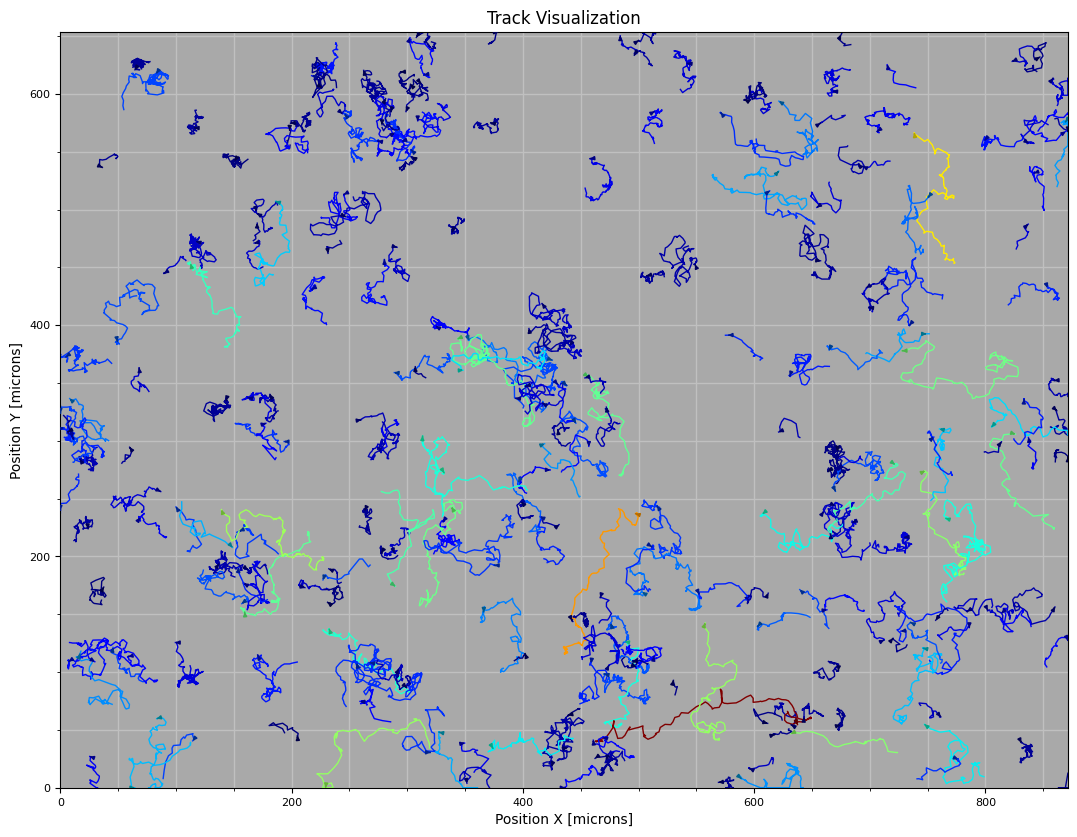

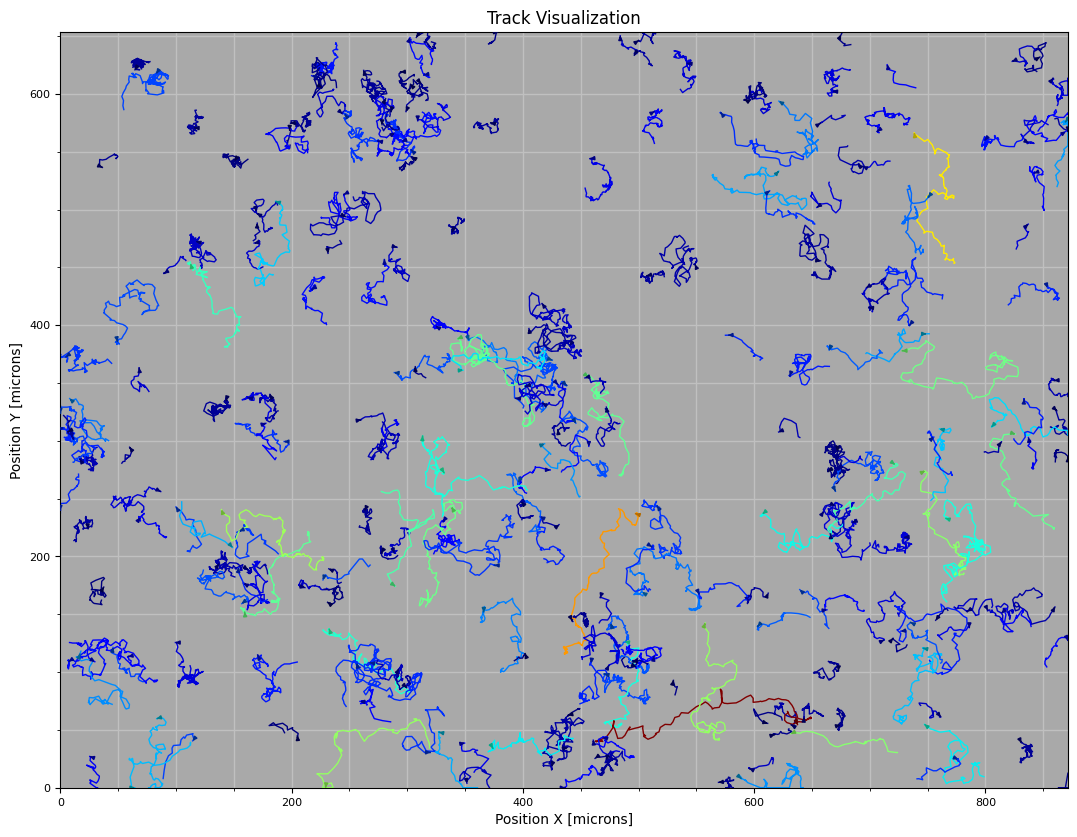

In [33]:
def track_visuals(df, df2, title_size=12):
    # fig and ax definition
    fig, ax = plt.subplots(figsize=(13, 10))

    # Ensuring that dataframse have required data
    track_ids = df2['TRACK_ID'].drop_duplicates()

    # Filter df2 to only include rows where TRACK_ID is in df's track_ids
    # df_filtered = df[df['TRACK_ID'].isin(track_ids)]

    net_distances = df2[['TRACK_ID', 'NET_DISTANCE']]

    # Normalize the NET_DISTANCE to a 0-1 range
    dmin = net_distances['NET_DISTANCE'].min()
    dmax = net_distances['NET_DISTANCE'].max()
    norm = plt.Normalize(vmin=dmin, vmax=dmax)
    colormap = plt.cm.jet

    # Create a dictionary to store the color for each track based on its confinement ratio
    track_colors = {}
    for track_id in track_ids:
        ratio = net_distances[net_distances['TRACK_ID'] == track_id]['NET_DISTANCE'].values[0]
        track_colors[track_id] = colormap(norm(ratio))

    # Set up the plot limits
    x_min, x_max = 0.0, 1180.3634496205236*microns_per_pixel
    y_min, y_max = 0.0, 885.0880400844326*microns_per_pixel
    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=title_size)
    ax.set_facecolor('darkgrey')
    ax.grid(True, which='both', axis='both', color='silver', linewidth=1)

    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)

    # Access and modify tick labels
    # for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    #      label.set_fontproperties(roboto_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)

    return fig, ax, track_ids, track_colors, norm, colormap

def visualize_full_tracks(df, df2, threshold, lw=1):  #Trakcs visualisation

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Using the  track_visuals function
    fig_visuals, ax_visuals, track_ids_visuals, track_colors_visuals, norm_visuals, colormap_visuals = track_visuals(df, df2)

    df = df.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])

    # Plot the full tracks
    for track_id in track_ids_visuals:
        track_data = df[df['TRACK_ID'] == track_id]
        x = track_data['POSITION_X']
        y = track_data['POSITION_Y']
        ax_visuals.plot(x, y, lw=lw, color=track_colors_visuals[track_id], label=f'Track {track_id}')
        
        # Get the original color from track_colors_visuals[track_id]
        original_color = mcolors.to_rgb(track_colors_visuals[track_id])
        # Darken the color by reducing the brightness (by scaling each RGB channel)
        darkened_color = np.array(original_color) * 0.7  # Adjust 0.7 to a value between 0 and 1 for different darkness levels
        # Ensure that no channel goes below 0 (clip values if necessary)
        darkened_color = np.clip(darkened_color, 0, 1)
        # Apply the darkened color with a slight increase in the green and blue channels for the original factor you had (optional)
        color = darkened_color * np.array([1.0, 1.0, 0.8])  # If you want to keep the original adjustment
    

        if len(x) > 1:
            # Add arrow to indicate direction
            dx = x.diff().iloc[-1]
            dy = y.diff().iloc[-1]
            if dx != 0 or dy != 0:
                # Create an arrow instead of a circle
                arrow = FancyArrowPatch(
                    posA=(x.iloc[-2], y.iloc[-2]),  # Start position (second-to-last point)
                    posB=(x.iloc[-1], y.iloc[-1]),  # End position (last point)
                    arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                    color=color,  # Set the color of the arrow
                    mutation_scale=5,  # Scale the size of the arrow head (adjust this based on the plot scale)
                    linewidth=1.2,  # Line width for the arrow
                    zorder=10  # Ensure the arrow is drawn on top of the line
                )

                # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
                plt.gca().add_patch(arrow)

    # plt.savefig(f'01a_Full_tracks_snapshot{threshold}.png', dpi=300)
    # plt.figure()
    return plt.gcf()


# =====================================================================================================================================================================
# =====================================================================================================================================================================
# =====================================================================================================================================================================





def extract_subdataframes(df, columns):

    subdataframes = []
    
    for value in df[columns[0]].unique():
        unique_cond = df[df[columns[0]] == value]
        for value2 in unique_cond[columns[1]].unique():
            unique_rep = unique_cond[unique_cond[columns[1]] == value2]
            subdataframes.append(unique_rep)
    
    return subdataframes

# Example usage:
# Suppose you have a dataframe called 'data' with a column 'CONDITION'
# subdfs = extract_subdataframes(data, column='CONDITION')
# Now, subdfs['Condition1'] contains all rows from 'data' where CONDITION == 'Condition1'

Spot_stats_list = extract_subdataframes(Spot_stats, columns=['CONDITION', 'REPLICATE'])
track_data_list = extract_subdataframes(Track_stats, columns=['CONDITION', 'REPLICATE'])

Spot_stats_1 = Spot_stats_list[0]
Track_stats_1 = track_data_list[0]
Spot_stats_2 = Spot_stats_list[1]
Track_stats_2 = track_data_list[1]
Spot_stats_3 = Spot_stats_list[2]
Track_stats_3 = track_data_list[2]

plt.show(visualize_full_tracks(Spot_stats_1, Track_stats_1, None, lw=1))
plt.show(visualize_full_tracks(Spot_stats_2, Track_stats_2, None, lw=1))
plt.show(visualize_full_tracks(Spot_stats_3, Track_stats_3, None, lw=1))

CONDITION  REPLICATE  TRACK_ID  TRACK_LENGTH  NET_DISTANCE  \
0            1          1         0    190.540029     24.331570   
1            1          1         1    239.386674     22.958469   
87           1          1         3    226.947239     13.208317   
125          1          1         4    344.089392     54.302333   
158          1          1         5    215.872367     35.664108   
..         ...        ...       ...           ...           ...   
174          1          1       532     27.400295     14.443515   
175          1          1       538     19.915872     14.959648   
177          1          1       540     27.083881     19.072280   
178          1          1       545     11.373882     10.218731   
179          1          1       546     19.860475     14.963920   

     CONFINEMENT_RATIO  MEAN_DIRECTION_DEG  STD_DEVIATION_DEG  \
0             0.127698          265.459344           4.464084   
1             0.095905          191.234122           2.277124   
87            0.058200          164.838442           0.800060   
125           0.157815          266.853185           2.322555   
158           0.165209           49.973030           0.742990   
..                 ...                 ...                ...   
174           0.527130          328.234855          14.747698   
175           0.751142          176.485343           3.674020   
177           0.704193          196.385642           3.084027   
178           0.898438          306.905949           5.520738   
179           0.753452          232.968524           9.381154   

     MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DEVIATION_RAD  \
0                     NaN           -1.650046           0.077913   
1                     NaN           -2.945520           0.039743   
87                    NaN            2.876974           0.013964   
125                   NaN           -1.625719           0.040536   
158                   NaN            0.872194           0.012968   
..                    ...                 ...                ...   
174                   NaN           -0.554406           0.257396   
175                   NaN            3.080250           0.064124   
177                   NaN           -2.855609           0.053826   
178                   NaN           -0.926666           0.096355   
179                   NaN           -2.217118           0.163732   

     MEDIAN_DIRECTION_RAD  NUM_FRAMES  SPEED_MIN  SPEED_MAX  SPEED_MEAN  \
0                     NaN         150          0   5.112263    1.270267   
1                     NaN         143          0   8.764059    1.674033   
87                    NaN         150          0   5.064273    1.512982   
125                   NaN         140          0  10.178575    2.457781   
158                   NaN         146          0   7.206576    1.478578   
..                    ...         ...        ...        ...         ...   
174                   NaN          16          0   3.981419    1.712518   
175                   NaN          14          0   3.217031    1.422562   
177                   NaN          12          0   5.449223    2.256990   
178                   NaN          12          0   2.476873    0.947824   
179                   NaN           9          0   5.054127    2.206719   

     SPEED_STD_DEVIATION  SPEED_MEDIAN  
0               0.989543      1.107627  
1               1.336833      1.547092  
87              1.027985      1.226694  
125             1.921087      2.237195  
158             1.251428      1.047220  
..                   ...           ...  
174             0.886335      1.678088  
175             1.142956      1.266981  
177             1.879059      1.907228  
178             0.740098      0.698008  
179             1.425099      2.224052  

[205 rows x 18 columns]

AttributeError: 'numpy.int64' object has no attribute 'split'

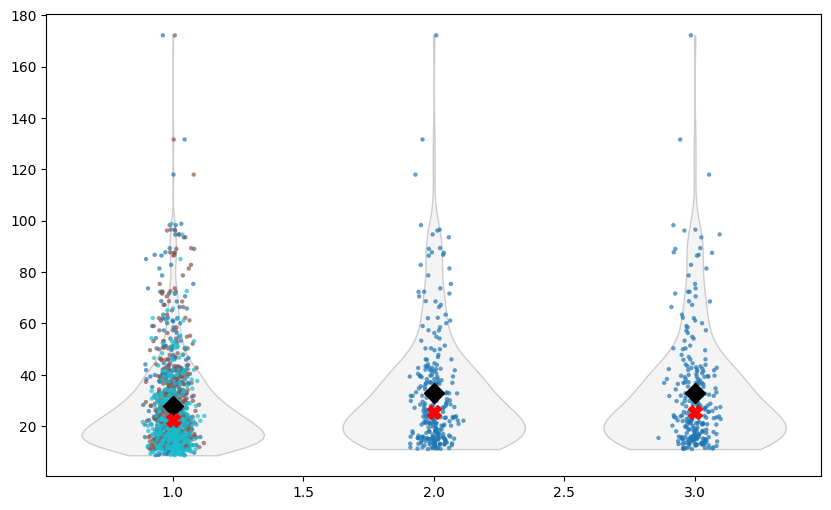

In [34]:
from scipy.stats import mannwhitneyu

def plot_violins(list_compiled_dfs, metric):
    """
    Creates a violin plot for the given metric from a list of DataFrames using matplotlib only.
    
    Each DataFrame is assumed to represent cell tracking data under a different condition.
    Each DataFrame must include a 'CONDITION' column with entries like 'control 1', 'control 2', etc.
    The overall condition label is extracted as the first word of the first entry in 'CONDITION'.
    
    Within each violin:
      - The distribution for each replicate (based on the full 'CONDITION' value) is overlaid using scatter points.
      - The overall mean (black diamond) and median (red "X") are computed and plotted.
    
    If exactly two conditions are provided, a Mann–Whitney U test is performed and its p value is annotated.
    
    Parameters:
        list_compiled_dfs (list): List of pandas DataFrames.
        metric (str): Column name in the DataFrames for the metric to plot.
    """
    num_conditions = len(list_compiled_dfs)
    
    # Prepare the data for the violin plots: one dataset per DataFrame.
    violin_data = [df[metric].values for df in list_compiled_dfs]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create violin plots at positions 1, 2, ... num_conditions.
    parts = ax.violinplot(violin_data, positions=np.arange(1, num_conditions+1),
                          widths=0.7, showextrema=False)
    
    # Customize the violins' appearance.
    for pc in parts['bodies']:
        pc.set_facecolor('gainsboro')
        pc.set_edgecolor('dimgrey')
        pc.set_alpha(0.3)
    
    # Overlay replicate data points and add mean/median markers.
    for i, df in enumerate(list_compiled_dfs):
        x_center = i + 1
        # Group by replicate using the full 'CONDITION' value.
        replicate_groups = df.groupby('CONDITION')
        replicates = list(replicate_groups.groups.keys())
        # Generate a color for each replicate.
        colors = plt.cm.tab10(np.linspace(0, 1, len(replicates)))
        for j, (rep_name, group) in enumerate(replicate_groups):
            # Create slight horizontal jitter around the center.
            x_jitter = np.random.normal(loc=x_center, scale=0.04, size=len(group))
            ax.scatter(x_jitter, group[metric].values, color=colors[j],
                       edgecolor='None', s=10, alpha=0.7,
                       label=rep_name if i == 0 else "")
        
        # Calculate overall mean and median for the condition.
        mean_val = df[metric].mean()
        median_val = df[metric].median()
        ax.plot(x_center, mean_val, marker='D', color='black', markersize=10,
                label='Mean' if i == 0 else "")
        ax.plot(x_center, median_val, marker='X', color='red', markersize=10,
                label='Median' if i == 0 else "")
    
    # If there are exactly two conditions, perform a Mann–Whitney U test.
    if num_conditions == 2:
        data1 = violin_data[0]
        data2 = violin_data[1]
        stat, p_val = mannwhitneyu(data1, data2)
        # Compute a y coordinate for annotation.
        all_data = np.concatenate((data1, data2))
        y_max = all_data.max()
        y_range = all_data.max() - all_data.min()
        y_offset = y_max + 0.05 * y_range
        # Place p value text between the two violins.
        ax.text(1.5, y_offset, f'p = {p_val:.3e}', ha='center', va='bottom', fontsize=12)
    
    # Use the overall condition label (first word of the first entry in 'CONDITION') for the x-tick labels.
    condition_labels = []
    for df in list_compiled_dfs:
        first_condition = df['CONDITION'].iloc[0]
        overall_label = first_condition.split()[0]
        condition_labels.append(overall_label)
    
    ax.set_xticks(np.arange(1, num_conditions+1))
    ax.set_xticklabels(condition_labels)
    ax.set_xlabel('Condition')
    ax.set_ylabel(metric)
    ax.set_title(f'Violin Plot of {metric} by Condition')
    
    # Build legend with unique labels.
    handles, labels = ax.get_legend_handles_labels()
    unique = {}
    for h, l in zip(handles, labels):
        if l not in unique:
            unique[l] = h
    ax.legend(unique.values(), unique.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Example usage:
A_list = [Track_stats, Track_stats_2, Track_stats_3]
B_list = [Track_stats_1, Track_stats_3]
display(Track_stats_1)
plot_violins(A_list, 'NET_DISTANCE')

AttributeError: 'numpy.int64' object has no attribute 'split'

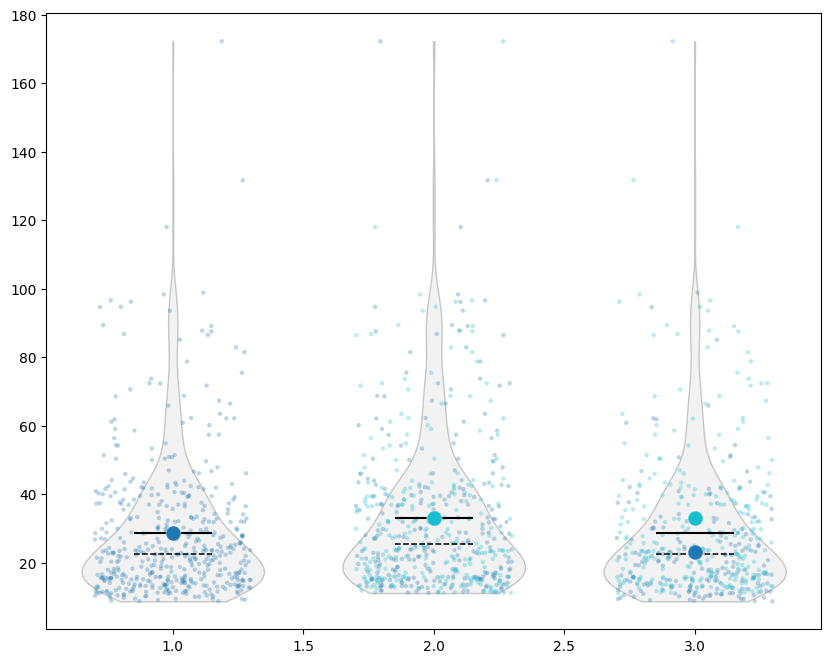

In [35]:
from scipy.stats import ttest_rel, ttest_ind
from itertools import combinations
from matplotlib import ticker


def plot_violins(list_compiled_dfs, metric):
    num_conditions = len(list_compiled_dfs)
    
    # Prepare the data for the violin plots: one dataset per DataFrame.
    violin_data = [df[metric].values for df in list_compiled_dfs]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create violin plots at positions 1, 2, ... num_conditions.
    parts = ax.violinplot(
        violin_data, 
        positions=np.arange(1, num_conditions+1),
        widths=0.7,
        showextrema=False)
    
    # Customize the violins' appearance.
    for pc in parts['bodies']:
        pc.set_facecolor('gainsboro')
        pc.set_edgecolor('dimgrey')
        pc.set_alpha(0.35)
    
    # Overlay replicate data points and add mean/median lines.
    for i, df in enumerate(list_compiled_dfs):
        x_center = i + 1

        # Group by replicate using the full 'CONDITION' value.
        replicate_groups = df.groupby('CONDITION')
        replicates = list(replicate_groups.groups.keys())

        # Generate a color for each replicate.
        colors = plt.cm.tab10(np.linspace(0, 1, len(replicates)))

        for j, (rep_name, group) in enumerate(replicate_groups):
            # Create slight horizontal jitter around the center.
            jitter_band = 0.3  # half-width of the band
            x_jitter = np.random.uniform(x_center - jitter_band, x_center + jitter_band, len(group))
            ax.scatter(x_jitter, group[metric].values, color=colors[j],
                   edgecolor='None', s=10, alpha=0.3)
            
        for j, (rep_name, group) in enumerate(replicate_groups):
            # Calculate the mean for each replicate and plot it with the same color.
            mean_val = group[metric].mean()
            ax.scatter(x_center, mean_val, color=colors[j], s=115, edgecolor=('white', 0.3), linewidth=1, zorder=3, marker='o')

        # Calculate overall mean and median for the condition.
        mean_val = df[metric].mean()
        median_val = df[metric].median()
        # Instead of markers, draw horizontal lines across the violin.
        ax.hlines(mean_val, x_center - 0.15, x_center + 0.15, color='black', linewidth=1.5, linestyles='-',
                  label='Mean' if i == 0 else "")
        ax.hlines(median_val, x_center - 0.15, x_center + 0.15, color='black', linewidth=1.1, linestyles='--',
                  label='Median' if i == 0 else "")
    
    # Use the overall condition label (first word of the first entry in 'CONDITION') for the x-tick labels.
    condition_labels = []
    for df in list_compiled_dfs:
        first_condition = df['CONDITION'].iloc[0]
        overall_label = first_condition.split()[0]
        condition_labels.append(overall_label)
    
    y_max = max([df[metric].max() for df in list_compiled_dfs]) * 1.25
    y_min = 0
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.set_xticks(np.arange(1, num_conditions+1))
    ax.set_xticklabels(condition_labels)
    ax.set_xlabel('Condition')
    ax.set_ylabel(metric)
    ax.set_title(f'Violin Plot of {metric} by Condition')
    
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    
    # --- Pairwise Statistical Tests (p-tests) ---
    annotation_offset = (y_max - y_min) * 0.03
    pairs = list(combinations(range(num_conditions), 2))
    for idx, (i, j) in enumerate(pairs):
        data1 = list_compiled_dfs[i][metric].values
        data2 = list_compiled_dfs[j][metric].values
        
        # Determine whether to use ttest_rel or ttest_ind
        if len(data1) == len(data2):
            stat, p_value = ttest_rel(data1, data2)
        else:
            stat, p_value = ttest_ind(data1, data2)
        
        local_max = max(np.max(data1), np.max(data2))
        height = local_max + annotation_offset * (idx + 1)
        
        x1, x2 = i + 1, j + 1
        ax.plot([x1, x1, x2, x2],
                [height - annotation_offset + 7.5, height+2, height+2, height - annotation_offset/5],
                lw=1.5, color='black')
        ax.text((x1 + x2) / 2, height+2.5, f"p = {p_value:.3f}",
                ha='center', va='bottom', color='black', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Example usage:
Test_track_data1 = pd.concat([Track_stats_1, Track_stats_2])
Test_track_data2 = pd.concat([Track_stats_2, Track_stats_3])
Test_track_data3 = pd.concat([Track_stats_1, Track_stats_3])

Test_track_list = [Test_track_data1, Test_track_data2, Test_track_data3]

# A_list = [Track_stats, Track_stats_2, Track_stats_3]
# B_list = [Track_stats_1, Track_stats_3]

plot_violins(Test_track_list, 'NET_DISTANCE')


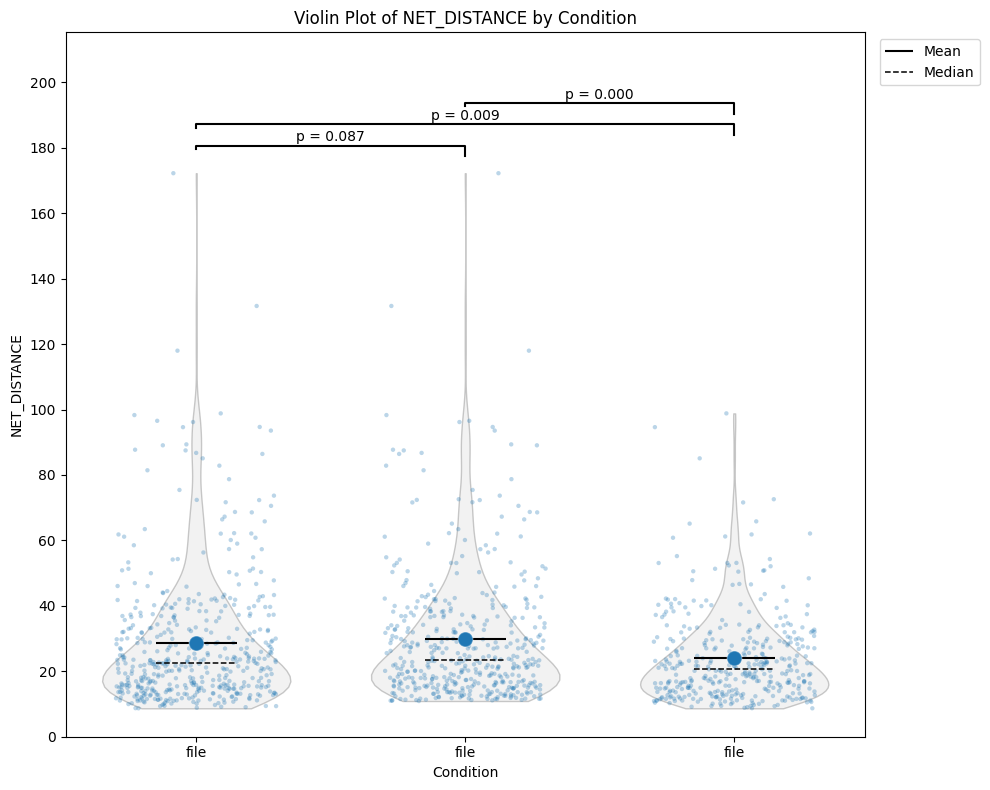

In [ ]:
from scipy.stats import ttest_rel, ttest_ind
from itertools import combinations
from matplotlib import ticker


def plot_violins(list_compiled_dfs, metric):
    num_conditions = len(list_compiled_dfs)
    
    # Prepare the data for the violin plots: one dataset per DataFrame.
    violin_data = [df[metric].values for df in list_compiled_dfs]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create violin plots at positions 1, 2, ... num_conditions.
    parts = ax.violinplot(
        violin_data, 
        positions=np.arange(1, num_conditions+1),
        widths=0.7,
        showextrema=False)
    
    # Customize the violins' appearance.
    for pc in parts['bodies']:
        pc.set_facecolor('gainsboro')
        pc.set_edgecolor('dimgrey')
        pc.set_alpha(0.35)
    
    # Overlay replicate data points and add mean/median lines.
    for i, df in enumerate(list_compiled_dfs):
        x_center = i + 1

        # Group by replicate using the full 'CONDITION' value.
        replicate_groups = df.groupby('CONDITION')
        replicates = list(replicate_groups.groups.keys())

        # Generate a color for each replicate.
        colors = plt.cm.tab10(np.linspace(0, 1, len(replicates)))

        for j, (rep_name, group) in enumerate(replicate_groups):
            # Create slight horizontal jitter around the center.
            jitter_band = 0.3  # half-width of the band
            x_jitter = np.random.uniform(x_center - jitter_band, x_center + jitter_band, len(group))
            ax.scatter(x_jitter, group[metric].values, color=colors[j],
                   edgecolor='None', s=10, alpha=0.3)
            
        for j, (rep_name, group) in enumerate(replicate_groups):
            # Calculate the mean for each replicate and plot it with the same color.
            mean_val = group[metric].mean()
            ax.scatter(x_center, mean_val, color=colors[j], s=115, edgecolor=('white', 0.3), linewidth=1, zorder=3, marker='o')

        # Calculate overall mean and median for the condition.
        mean_val = df[metric].mean()
        median_val = df[metric].median()
        # Instead of markers, draw horizontal lines across the violin.
        ax.hlines(mean_val, x_center - 0.15, x_center + 0.15, color='black', linewidth=1.5, linestyles='-',
                  label='Mean' if i == 0 else "")
        ax.hlines(median_val, x_center - 0.15, x_center + 0.15, color='black', linewidth=1.1, linestyles='--',
                  label='Median' if i == 0 else "")
    
    # Use the overall condition label (first word of the first entry in 'CONDITION') for the x-tick labels.
    condition_labels = []
    for df in list_compiled_dfs:
        first_condition = df['CONDITION'].iloc[0]
        overall_label = first_condition.split()[0]
        condition_labels.append(overall_label)
    
    y_max = max([df[metric].max() for df in list_compiled_dfs]) * 1.25
    y_min = 0
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.set_xticks(np.arange(1, num_conditions+1))
    ax.set_xticklabels(condition_labels)
    ax.set_xlabel('Condition')
    ax.set_ylabel(metric)
    ax.set_title(f'Violin Plot of {metric} by Condition')
    
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    
    # --- Pairwise Statistical Tests (p-tests) ---
    annotation_offset = (y_max - y_min) * 0.03
    pairs = list(combinations(range(num_conditions), 2))
    for idx, (i, j) in enumerate(pairs):
        data1 = list_compiled_dfs[i][metric].values
        data2 = list_compiled_dfs[j][metric].values
        
       
        """
        if "comparing replicates":
            stat, p_value = ttest_rel(data1, data2)
        elif "comparing whole datasets": 
            stat, p_value = mannwhitneyu(data1, data2)
        """

        stat, p_value = mannwhitneyu(data1, data2)
        
        local_max = max(np.max(data1), np.max(data2))
        height = local_max + annotation_offset * (idx + 1)
        
        x1, x2 = i + 1, j + 1
        ax.plot([x1, x1, x2, x2],
                [height - annotation_offset + 7.5, height+2, height+2, height - annotation_offset/5],
                lw=1.5, color='black')
        ax.text((x1 + x2) / 2, height+2.5, f"p = {p_value:.3f}",
                ha='center', va='bottom', color='black', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Example usage:
Test_track_data1 = pd.concat([Track_stats_1, Track_stats_2])
Test_track_data2 = pd.concat([Track_stats_2, Track_stats_3])
Test_track_data3 = pd.concat([Track_stats_1, Track_stats_3])

Test_track_list = [Test_track_data1, Test_track_data2, Test_track_data3]

# A_list = [Track_stats, Track_stats_2, Track_stats_3]
# B_list = [Track_stats_1, Track_stats_3]

plot_violins(Test_track_list, 'NET_DISTANCE')


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_swarm(list_compiled_dfs, metric):
    """
    Creates a swarm plot for the given metric from a list of DataFrames using seaborn.

    Each DataFrame is assumed to represent cell tracking data under a different condition.
    Each DataFrame must include a 'CONDITION' column with entries like 'A replicate 1', 'B replicate 2', etc.

    Parameters:
        list_compiled_dfs (list): List of pandas DataFrames.
        metric (str): Column name in the DataFrames for the metric to plot.
    """
    # Combine all DataFrames into one for plotting
    combined_df = pd.concat(list_compiled_dfs, ignore_index=True)
    
    # Extract the overall condition label (first word of the 'CONDITION' column)
    combined_df['Overall_Condition'] = combined_df['CONDITION'].str.split().str[0]
    
    # Get unique conditions and generate a consistent color palette
    unique_conditions = combined_df['CONDITION'].unique()
    palette = sns.color_palette("tab10", n_colors=len(unique_conditions))  # Generate a distinct color for each condition
    
    # Create the swarm plot
    plt.figure(figsize=(12, 8))
    sns.swarmplot(data=combined_df, x='Overall_Condition', y=metric, hue='CONDITION', 
                  palette=dict(zip(unique_conditions, palette)), size=5, dodge=True)

    # Customize the plot
    plt.xlabel('Condition', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.title(f'Swarm Plot of {metric} by Condition', fontsize=14)
    plt.legend(title='Replicates', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()

# Example usage:
Test_track_data1 = pd.concat([Track_stats_1, Track_stats_2])
Test_track_data2 = pd.concat([Track_stats_2, Track_stats_3])
Test_track_data3 = pd.concat([Track_stats_1, Track_stats_3])

Test_track_list = [Test_track_data1, Test_track_data2, Test_track_data3]

plot_swarm(Test_track_list, 'NET_DISTANCE')


AttributeError: Can only use .str accessor with string values!

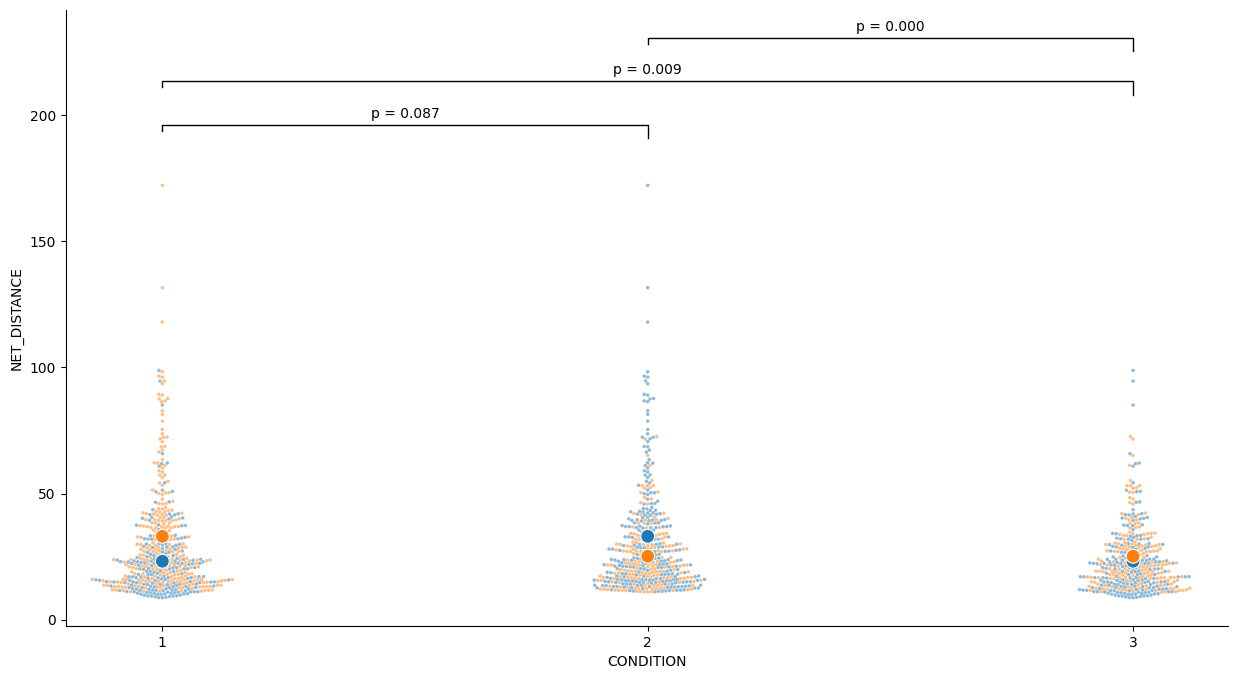

In [172]:
def my_data_swarm_plot_with_p_tests(df, metric):
    plt.figure(figsize=(15, 8))
    
    # Ensure CONDITION is treated as categorical
    df['CONDITION'] = df['CONDITION'].astype(str)
    
    sns.swarmplot(data=df, x='CONDITION', y=metric, hue='REPLICATE', palette='tab10', size=2.5, dodge=False, alpha=0.5, zorder=0, legend=False)
    sns.despine()
    
    replicate_means = df.groupby(['CONDITION', 'REPLICATE'])[metric].mean().reset_index()
    
    sns.scatterplot(data=replicate_means, x='CONDITION', y=metric, hue='REPLICATE', palette='tab10', s=100, legend=False)
    
    ''' P-test
    # Perform pairwise p-tests
    conditions = df['CONDITION'].unique()
    pairs = list(combinations(conditions, 2))
    y_max = df[metric].max()
    y_offset = (y_max * 0.1)  # Offset for p-value annotations
    for i, (cond1, cond2) in enumerate(pairs):
        data1 = df[df['CONDITION'] == cond1][metric]
        data2 = df[df['CONDITION'] == cond2][metric]
        stat, p_value = mannwhitneyu(data1, data2)
        
        # Annotate the plot with the p-value
        x1, x2 = conditions.tolist().index(cond1), conditions.tolist().index(cond2)
        y = y_max + y_offset * (i + 1)
        plt.plot([x1, x1, x2, x2], [y+4.5, y + y_offset / 2.5, y + y_offset / 2.5, y+1.5], lw=1, color='black')
        plt.text((x1 + x2) / 2, y + y_offset / 2, f'p = {round(p_value, 3):.3f}', ha='center', va='bottom', fontsize=10, color='black')
    '''
    
    plt.show()

# Example usage:
my_data_swarm_plot_with_p_tests(Track_stats, 'NET_DISTANCE')



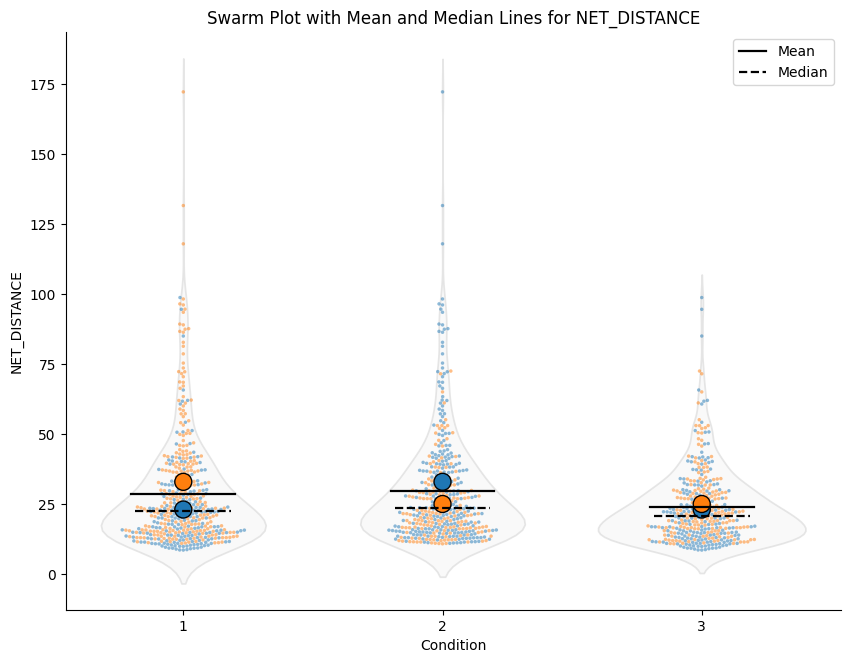

In [229]:
def my_data_swarm_plot_with_mean_median(df, metric):
    plt.figure(figsize=(10, 7.5))
    
    # Ensure CONDITION is treated as categorical
    df['CONDITION'] = df['CONDITION'].astype(str)

    swarm_size = 2.5
    swarm_alpha = 0.5

    violin_fill_color = 'whitesmoke'
    violin_edge_color = 'lightgrey'
    violin_alpha = 0.55

    mean_span = 0.2
    median_span = 0.185
    line_width = 1.6
    
    sns.swarmplot(data=df, x='CONDITION', y=metric, hue='REPLICATE', palette='tab10', size=swarm_size, dodge=False, alpha=swarm_alpha, zorder=1, legend=False)
    sns.despine()

    replicate_means = df.groupby(['CONDITION', 'REPLICATE'])[metric].mean().reset_index()
    sns.scatterplot(data=replicate_means, x='CONDITION', y=metric, hue='REPLICATE', palette='tab10', edgecolor='black', s=150, zorder=3, legend=False)
    
    sns.violinplot(data=df, x='CONDITION', y=metric, color=violin_fill_color, edgecolor=violin_edge_color, inner=None, alpha=violin_alpha, zorder=0)

    # Calculate mean and median for each condition
    condition_stats = df.groupby('CONDITION')[metric].agg(['mean', 'median']).reset_index()

    # Plot mean and median lines for each condition using seaborn functions
    for i, row in condition_stats.iterrows():
        x_center = i # Adjust x-coordinate to start at the correct condition position
        sns.lineplot(x=[x_center - mean_span, x_center + mean_span], y=[row['mean'], row['mean']], color='black', linestyle='-', linewidth=line_width, zorder=4, label='Mean' if i == 0 else "")
        sns.lineplot(x=[x_center - median_span, x_center + median_span], y=[row['median'], row['median']], color='black', linestyle='--', linewidth=line_width, zorder=4, label='Median' if i == 0 else "")

    ''' P-test
    # Perform pairwise p-tests
    conditions = df['CONDITION'].unique()
    pairs = list(combinations(conditions, 2))
    y_max = df[metric].max()
    y_offset = (y_max * 0.1)  # Offset for p-value annotations
    for i, (cond1, cond2) in enumerate(pairs):
        data1 = df[df['CONDITION'] == cond1][metric]
        data2 = df[df['CONDITION'] == cond2][metric]
        stat, p_value = mannwhitneyu(data1, data2)
        
        # Annotate the plot with the p-value
        x1, x2 = conditions.tolist().index(cond1), conditions.tolist().index(cond2)
        y = y_max + y_offset * (i + 1)
        plt.plot([x1, x1, x2, x2], [y+4.5, y + y_offset / 2.5, y + y_offset / 2.5, y+1.5], lw=1, color='black')
        plt.text((x1 + x2) / 2, y + y_offset / 2, f'p = {round(p_value, 3):.3f}', ha='center', va='bottom', fontsize=10, color='black')
    '''
    
    plt.legend(loc='upper right')
    plt.title(f"Swarm Plot with Mean and Median Lines for {metric}")
    plt.xlabel("Condition")
    plt.ylabel(metric)
    plt.show()

# Example usage:
my_data_swarm_plot_with_mean_median(Track_stats, 'NET_DISTANCE')


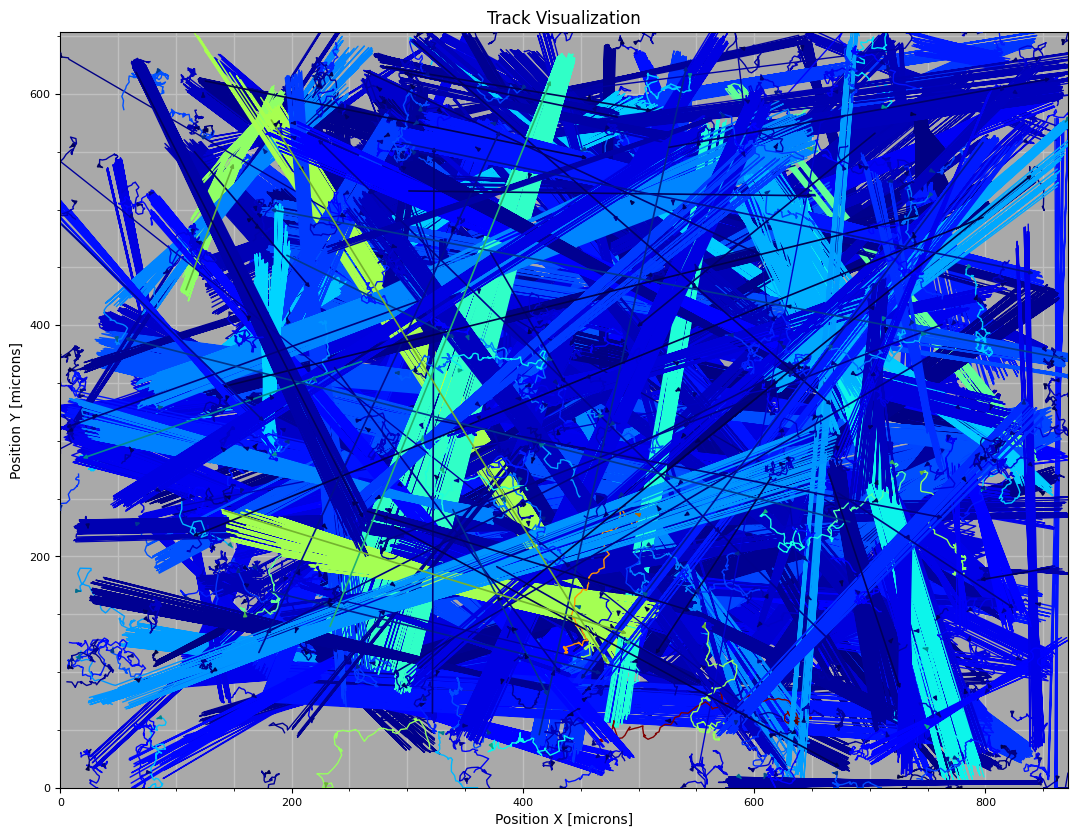

In [ ]:
def track_visuals(df, df2, title_size=12):
    # fig and ax definition
    fig, ax = plt.subplots(figsize=(13, 10))

    # Ensuring that dataframse have required data
    track_ids = df2['TRACK_ID'].drop_duplicates()

    # Filter df2 to only include rows where TRACK_ID is in df's track_ids
    # df_filtered = df[df['TRACK_ID'].isin(track_ids)]

    net_distances = df2[['CONDITION','TRACK_ID', 'NET_DISTANCE']]

    # Normalize the NET_DISTANCE to a 0-1 range
    dmin = net_distances['NET_DISTANCE'].min()
    dmax = net_distances['NET_DISTANCE'].max()
    norm = plt.Normalize(vmin=dmin, vmax=dmax)
    colormap = plt.cm.jet

    # Create a dictionary to store the color for each track based on its confinement ratio
    track_colors = {}
    for track_id in track_ids:
        ratio = net_distances[net_distances['TRACK_ID'] == track_id]['NET_DISTANCE'].values[0]
        track_colors[track_id] = colormap(norm(ratio))

    # Set up the plot limits
    x_min, x_max = 0.0, 1180.3634496205236*microns_per_pixel
    y_min, y_max = 0.0, 885.0880400844326*microns_per_pixel
    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=title_size)
    ax.set_facecolor('darkgrey')
    ax.grid(True, which='both', axis='both', color='silver', linewidth=1)

    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)

    # Access and modify tick labels
    # for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    #      label.set_fontproperties(roboto_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)

    return fig, ax, track_ids, track_colors, norm, colormap

def visualize_full_tracks(df, df2, threshold, lw=1):  #Trakcs visualisation

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Using the  track_visuals function
    fig_visuals, ax_visuals, track_ids_visuals, track_colors_visuals, norm_visuals, colormap_visuals = track_visuals(df, df2)

    df = df.sort_values(by=['CONDITION', 'TRACK_ID', 'POSITION_T'])

    # Plot the full tracks
    for track_id in track_ids_visuals:
        track_data = df[df['TRACK_ID'] == track_id]
        x = track_data['POSITION_X']
        y = track_data['POSITION_Y']
        ax_visuals.plot(x, y, lw=lw, color=track_colors_visuals[track_id], label=f'Track {track_id}')
        
        # Get the original color from track_colors_visuals[track_id]
        original_color = mcolors.to_rgb(track_colors_visuals[track_id])
        # Darken the color by reducing the brightness (by scaling each RGB channel)
        darkened_color = np.array(original_color) * 0.7  # Adjust 0.7 to a value between 0 and 1 for different darkness levels
        # Ensure that no channel goes below 0 (clip values if necessary)
        darkened_color = np.clip(darkened_color, 0, 1)
        # Apply the darkened color with a slight increase in the green and blue channels for the original factor you had (optional)
        color = darkened_color * np.array([1.0, 1.0, 0.8])  # If you want to keep the original adjustment
    

        if len(x) > 1:
            # Add arrow to indicate direction
            dx = x.diff().iloc[-1]
            dy = y.diff().iloc[-1]
            if dx != 0 or dy != 0:
                # Create an arrow instead of a circle
                arrow = FancyArrowPatch(
                    posA=(x.iloc[-2], y.iloc[-2]),  # Start position (second-to-last point)
                    posB=(x.iloc[-1], y.iloc[-1]),  # End position (last point)
                    arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                    color=color,  # Set the color of the arrow
                    mutation_scale=5,  # Scale the size of the arrow head (adjust this based on the plot scale)
                    linewidth=1.2,  # Line width for the arrow
                    zorder=10  # Ensure the arrow is drawn on top of the line
                )

                # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
                plt.gca().add_patch(arrow)

    # plt.savefig(f'01a_Full_tracks_snapshot{threshold}.png', dpi=300)
    # plt.figure()
    return plt.gcf()

plt.show(visualize_full_tracks(Spot_stats, track_data, None, lw=1))

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Function execution &#x1F3D7;
---
&#x1F6A7; *waiting to be described* &#x1F6A7;

## Thresholding &#x1F3D7;
---
[Function with defined thresholds extracting various dataframes]

&#x1F6A7; *under construction* &#x1F6A7;

In [ ]:
def split_dataframe_by_percentiles(df, column_name):
    # Get to know the data frames name
    df_name = [name for name, value in globals().items() if value is df][0]

    # Dictionary to store each DataFrame filtered by percentiles
    dataframes_by_percentile = {}

    # Calculate percentiles and filter the DataFrame for each
    for percentile in range(10, 100, 10):
        threshold_value = df[column_name].quantile(percentile / 100)
        filtered_df = df[df[column_name] > threshold_value]

        # Save the DataFrame
        filename = f'{df_name}_with_{column_name}_thresholded_at_{percentile}th_percentile.csv'
        filtered_df.to_csv(op.join(save_path, filename), index=False)

        # Store in dictionary (optional)
        dataframes_by_percentile[f'threshold_at_{percentile}th_percentile'] = filtered_df

    # Accessing a specific DataFrame for, say, the 30th percentile
    df_thresholded_at_10th_percentile = dataframes_by_percentile['threshold_at_10th_percentile'] # 10th
    df_thresholded_at_20th_percentile = dataframes_by_percentile['threshold_at_20th_percentile'] # 20th
    df_thresholded_at_30th_percentile = dataframes_by_percentile['threshold_at_30th_percentile'] # 30th
    df_thresholded_at_40th_percentile = dataframes_by_percentile['threshold_at_40th_percentile'] # 40th
    df_thresholded_at_50th_percentile = dataframes_by_percentile['threshold_at_50th_percentile'] # 50th
    df_thresholded_at_60th_percentile = dataframes_by_percentile['threshold_at_60th_percentile'] # 60th
    df_thresholded_at_70th_percentile = dataframes_by_percentile['threshold_at_70th_percentile'] # 70th
    df_thresholded_at_80th_percentile = dataframes_by_percentile['threshold_at_80th_percentile'] # 80th
    df_thresholded_at_90th_percentile = dataframes_by_percentile['threshold_at_90th_percentile'] # 90th


    return df_thresholded_at_10th_percentile, df_thresholded_at_20th_percentile, df_thresholded_at_30th_percentile, df_thresholded_at_40th_percentile, df_thresholded_at_50th_percentile, df_thresholded_at_60th_percentile, df_thresholded_at_70th_percentile, df_thresholded_at_80th_percentile, df_thresholded_at_90th_percentile
Track_stats_thresholded_at_10th_percentile, Track_stats_thresholded_at_20th_percentile, Track_stats_thresholded_at_30th_percentile, Track_stats_thresholded_at_40th_percentile, Track_stats_thresholded_at_50th_percentile, Track_stats_thresholded_at_60th_percentile, Track_stats_thresholded_at_70th_percentile, Track_stats_thresholded_at_80th_percentile, Track_stats_thresholded_at_90th_percentile = split_dataframe_by_percentiles(Track_stats, 'NET_DISTANCE')

# You should try: split_dataframe_by_percentiles(df, column_name); column_name = 'NET_DISTANCE', 'TRACK_LENGTH', 'CONFINEMENT_RATIO', 'SPEED_MEDIAN AND OR MEAN, ETC 


NameError: name 'save_path' is not defined

## Visualizers, Plots, Histograms &#x1F3D7;
---
&#x1F6A7; *waiting to be described* &#x1F6A7;

---
### Defining the optic parameters
Defining the pixel length, imaging winfow parameters and aspect ratio based on the microscope:

In [ ]:
# Definition of micron length per pixel
microns_per_pixel = 0.7381885238402274 # for 10x lens

# Define the desired dimensions in microns
x_min, x_max = 0, (1600 * microns_per_pixel)
y_min, y_max = 0, (1200 * microns_per_pixel)
x_axe_remainder = x_max-1150
x_add = 50 - x_axe_remainder
y_ax_remainder = y_max-850
x_substract = (x_max - y_max) + (y_ax_remainder - 50)

# Calculate the aspect ratio
aspect_ratio = x_max / y_max

In [ ]:
title_size = 18
label_size = 11
figtext_size = 9
compass_annotations_size = 15
figtext_color = 'grey'

---
### Defining settings and the parametres for track visualization &#x1F3D7;

Defining the settings and parametres for visualization separately, so that they need not be defined over again in each of the different track visualizations

&#x1F6A7; *under construction* &#x1F6A7; 

In [ ]:
def track_visuals(df, df2):
    # fig and ax definition
    fig, ax = plt.subplots(figsize=(13, 10))

    # Ensuring that dataframse have required data
    track_ids = df2['TRACK_ID'].unique()

    # Filter df2 to only include rows where TRACK_ID is in df's track_ids
    df_filtered = df[df['TRACK_ID'].isin(track_ids)]

    net_distances = df2[['TRACK_ID', 'NET_DISTANCE']]

    # Normalize the NET_DISTANCE to a 0-1 range
    dmin = net_distances['NET_DISTANCE'].min()
    dmax = net_distances['NET_DISTANCE'].max()
    norm = plt.Normalize(vmin=dmin, vmax=dmax)
    colormap = plt.cm.jet

    # Create a dictionary to store the color for each track based on its confinement ratio
    track_colors = {}
    for track_id in track_ids:
        ratio = net_distances[net_distances['TRACK_ID'] == track_id]['NET_DISTANCE'].values[0]
        track_colors[track_id] = colormap(norm(ratio))

    # Set up the plot limits
    x_min, x_max = df_filtered['POSITION_X'].min(), df_filtered['POSITION_X'].max()
    y_min, y_max = df_filtered['POSITION_Y'].min(), df_filtered['POSITION_Y'].max()
    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=title_size)
    ax.set_facecolor('dimgrey')
    ax.grid(True, which='both', axis='both', color='grey', linewidth=1)

    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)
    

    # Access and modify tick labels
    # for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    #      label.set_fontproperties(roboto_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)

    return fig, ax, track_ids, track_colors, norm, colormap

---
### Visualizing the tracks &#x1F3D7;

*Overview of the tracks:*

&#x1F6A7; *under construction* &#x1F6A7; 

In [ ]:
def track_visuals(df, df2):
    # fig and ax definition
    fig, ax = plt.subplots(figsize=(13, 10))

    # Ensuring that dataframse have required data
    track_ids = df2['TRACK_ID'].unique()

    # Filter df2 to only include rows where TRACK_ID is in df's track_ids
    df_filtered = df[df['TRACK_ID'].isin(track_ids)]

    net_distances = df2[['TRACK_ID', 'NET_DISTANCE']]

    # Normalize the NET_DISTANCE to a 0-1 range
    dmin = net_distances['NET_DISTANCE'].min()
    dmax = net_distances['NET_DISTANCE'].max()
    norm = plt.Normalize(vmin=dmin, vmax=dmax)
    colormap = plt.cm.jet

    # Create a dictionary to store the color for each track based on its confinement ratio
    track_colors = {}
    for track_id in track_ids:
        ratio = net_distances[net_distances['TRACK_ID'] == track_id]['NET_DISTANCE'].values[0]
        track_colors[track_id] = colormap(norm(ratio))

    # Set up the plot limits
    x_min, x_max = df_filtered['POSITION_X'].min(), df_filtered['POSITION_X'].max()
    y_min, y_max = df_filtered['POSITION_Y'].min(), df_filtered['POSITION_Y'].max()
    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=title_size)
    ax.set_facecolor('dimgrey')

    # Manually draw rotated gridlines
    color = 'grey'     # Gridline color
    alpha = 0.2        # Gridline transparency
    lw = 0.6           # Gridline width
    grid_spacing = 50  # Adjust the spacing of gridlines
    angle1 = 45        # Rotation angle in degrees
    angle2 = -45       # Rotation angle in degrees
    z_order = 0.5      # Gridline z-order

    for x in np.arange(x_min, x_max, grid_spacing):
        for y in np.arange(y_min, y_max, grid_spacing):
            # Compute the rotated line endpoints
            x_lines_a = [x, x + (y_max - y_min) * np.tan(np.radians(angle1))]
            y_lines_a = [y, y + (x_max - x_min) * np.tan(np.radians(angle1))]
            x_lines_b = [x, x + (y_max - y_min) * np.tan(np.radians(angle2))]
            y_lines_b = [y, y + (x_max - x_min) * np.tan(np.radians(angle2))]
            ax.plot(x_lines_a, [y_min, y_max], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)
            ax.plot(y_lines_a, [(x_max+x_add), (x_min+x_add)], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)
            ax.plot(x_lines_b, [y_min, y_max], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)
            ax.plot(y_lines_b, [(x_max - x_substract), (x_min - x_substract)], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)

    # Standard gridlines (optional)
    ax.grid(False)  # Turn off default gridlines


    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)
    

    # Access and modify tick labels
    # for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    #      label.set_fontproperties(roboto_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)

    return fig, ax, track_ids, track_colors, norm, colormap

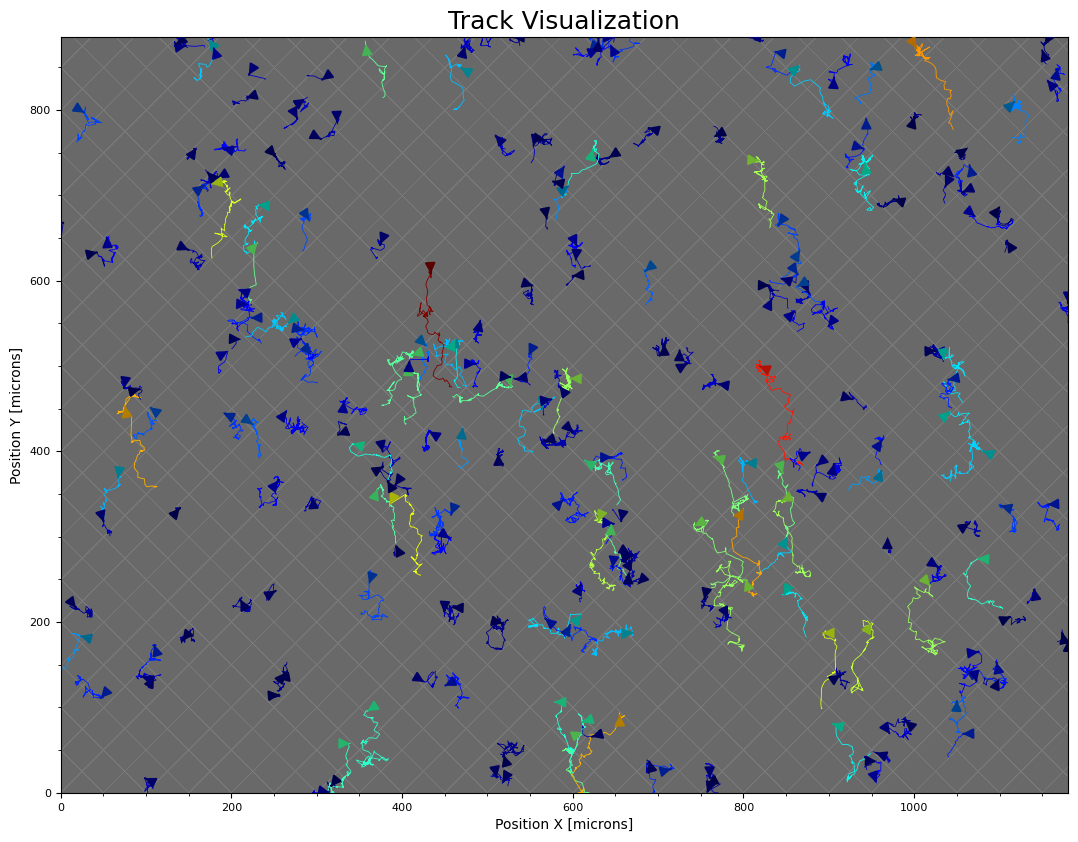

In [ ]:
def visualize_full_tracks(df, df2, threshold, lw=1):  #Trakcs visualisation

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Using the  track_visuals function
    fig_visuals, ax_visuals, track_ids_visuals, track_colors_visuals, norm_visuals, colormap_visuals = track_visuals(df, df2)

    # Plot the full tracks
    for track_id in track_ids_visuals:
        track_data = df[df['TRACK_ID'] == track_id]
        x = track_data['POSITION_X']
        y = track_data['POSITION_Y']
        ax_visuals.plot(x, y, lw=lw, color=track_colors_visuals[track_id], label=f'Track {track_id}')
        
        # Get the original color from track_colors_visuals[track_id]
        original_color = mcolors.to_rgb(track_colors_visuals[track_id])
        # Darken the color by reducing the brightness (by scaling each RGB channel)
        darkened_color = np.array(original_color) * 0.7  # Adjust 0.7 to a value between 0 and 1 for different darkness levels
        # Ensure that no channel goes below 0 (clip values if necessary)
        darkened_color = np.clip(darkened_color, 0, 1)
        # Apply the darkened color with a slight increase in the green and blue channels for the original factor you had (optional)
        color = darkened_color * np.array([1.0, 1.0, 0.8])  # If you want to keep the original adjustment
    

        if len(x) > 1:
            # Add arrow to indicate direction
            dx = x.diff().iloc[-1]
            dy = y.diff().iloc[-1]
            if dx != 0 or dy != 0:
                # Create an arrow instead of a circle
                arrow = FancyArrowPatch(
                    posA=(x.iloc[-2], y.iloc[-2]),  # Start position (second-to-last point)
                    posB=(x.iloc[-1], y.iloc[-1]),  # End position (last point)
                    arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                    color=color,  # Set the color of the arrow
                    mutation_scale=15,  # Scale the size of the arrow head (adjust this based on the plot scale)
                    linewidth=1.5,  # Line width for the arrow
                    zorder=10  # Ensure the arrow is drawn on top of the line
                )

                # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
                plt.gca().add_patch(arrow)

    plt.savefig((op.join(save_path, f'01a_Full_tracks_snapshot{threshold}.png')), dpi=300)
    # plt.show()
visualize_full_tracks(butter_df, Track_stats, None, lw=0.6)
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_20th_percentile, 'thresholded_at_20th_percentile') # 20th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_40th_percentile, 'thresholded_at_40th_percentile') # 40th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_60th_percentile, 'thresholded_at_60th_percentile') # 60th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_80th_percentile, 'thresholded_at_80th_percentile') # 80th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_90th_percentile, 'thresholded_at_90th_percentile') # 90th

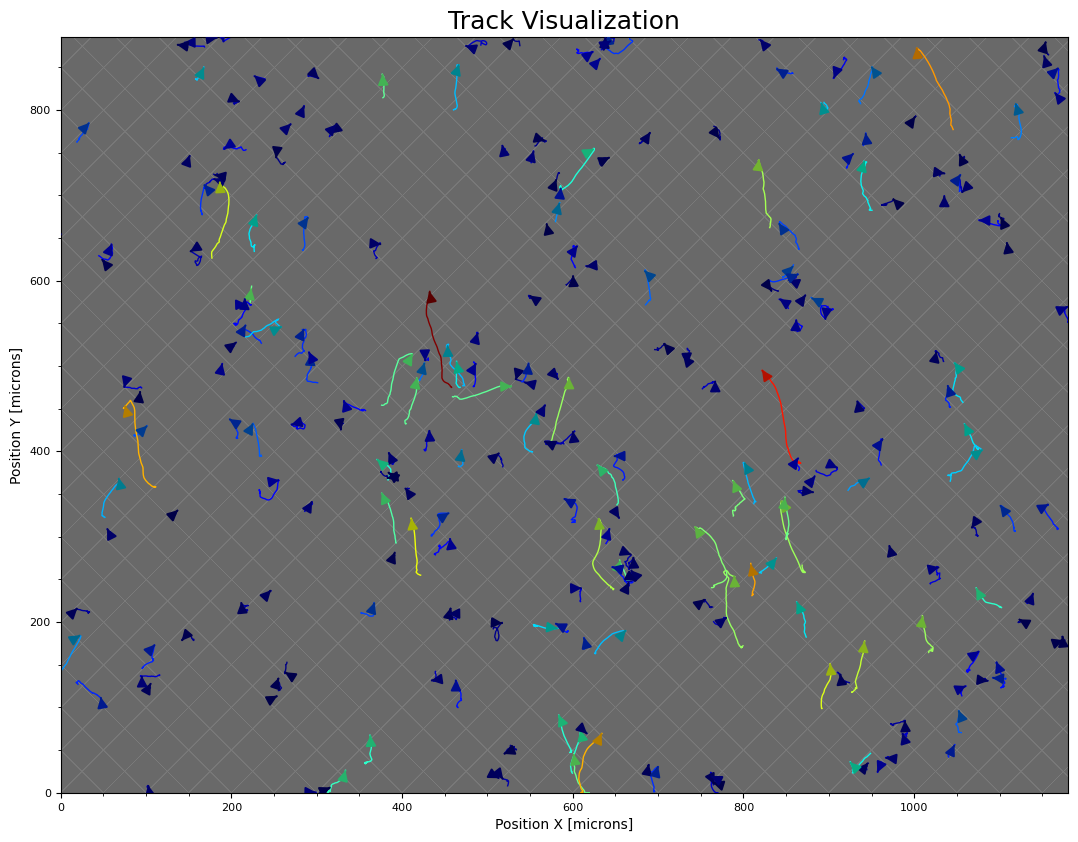

In [ ]:
def visualize_smoothed_tracks(df, df2, threshold, smoothing_type=None, smoothing_index=10, lw=1):  # Tracks visualization

    # Recognizing the presence of a threshold
    if threshold is None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Using the track_visuals function
    fig_visuals, ax_visuals, track_ids_visuals, track_colors_visuals, norm_visuals, colormap_visuals = track_visuals(df, df2)

    # Plot the full tracks
    for track_id in track_ids_visuals:
        track_data = df[df['TRACK_ID'] == track_id]
        x = track_data['POSITION_X']
        y = track_data['POSITION_Y']
        
        # Apply smoothing to the track (if applicable)
        if smoothing_type == 'moving_average':
            x_smoothed = x.rolling(window=smoothing_index, min_periods=1).mean()
            y_smoothed = y.rolling(window=smoothing_index, min_periods=1).mean()
        else:
            x_smoothed = x
            y_smoothed = y

        ax_visuals.plot(x_smoothed, y_smoothed, lw=lw, color=track_colors_visuals[track_id], label=f'Track {track_id}')

        # Get the original color from track_colors_visuals[track_id]
        original_color = mcolors.to_rgb(track_colors_visuals[track_id])
        # Darken the color by reducing the brightness (by scaling each RGB channel)
        darkened_color = np.array(original_color) * 0.7  # Adjust 0.7 to a value between 0 and 1 for different darkness levels
        # Ensure that no channel goes below 0 (clip values if necessary)
        darkened_color = np.clip(darkened_color, 0, 1)
        # Apply the darkened color with a slight increase in the green and blue channels for the original factor you had (optional)
        color = darkened_color * np.array([1.0, 1.0, 0.8])  # If you want to keep the original adjustment


        if len(x_smoothed) > 1:
            # Extract the mean direction from df2 for the current track
            mean_direction_rad = df2[df2['TRACK_ID'] == track_id]['MEAN_DIRECTION_RAD'].values[0]
            
            # Use trigonometry to calculate the direction (dx, dy) from the angle
            dx = np.cos(mean_direction_rad)  # Change in x based on angle
            dy = np.sin(mean_direction_rad)  # Change in y based on angle
            
            # Create an arrow to indicate direction
            arrow = FancyArrowPatch(
                posA=(x_smoothed.iloc[-2], y_smoothed.iloc[-2]),  # Start position (second-to-last point)
                posB=(x_smoothed.iloc[-2] + dx, y_smoothed.iloc[-2] + dy),  # End position based on direction
                arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                color=color,  # Set the color of the arrow
                mutation_scale=15,  # Scale the size of the arrow head (adjust this based on the plot scale)
                linewidth=1.5,  # Line width for the arrow
                zorder=30  # Ensure the arrow is drawn on top of the line
            )

            # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
            plt.gca().add_patch(arrow)

    plt.savefig((op.join(save_path, f'01a_Full_tracks_snapshot{threshold}.png')), dpi=300)
    # plt.show()

# Example usage
visualize_smoothed_tracks(butter_df, Track_stats, None, smoothing_type='moving_average', smoothing_index=50, lw=1)


---
### Histograms describing cell motility &#x1F3D7;

*Histogram plotting all cells in the dataset and its migrated distance together with the time window in which it has been imaged:*

&#x1F6A7; *under construction* &#x1F6A7; 

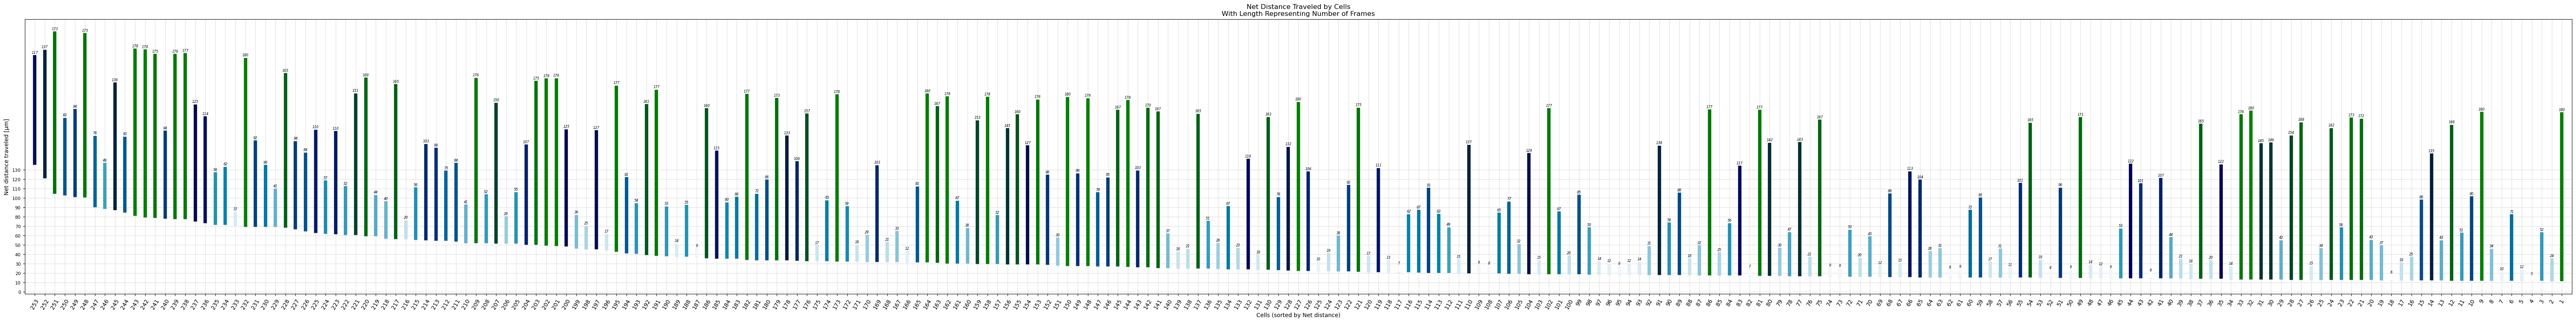

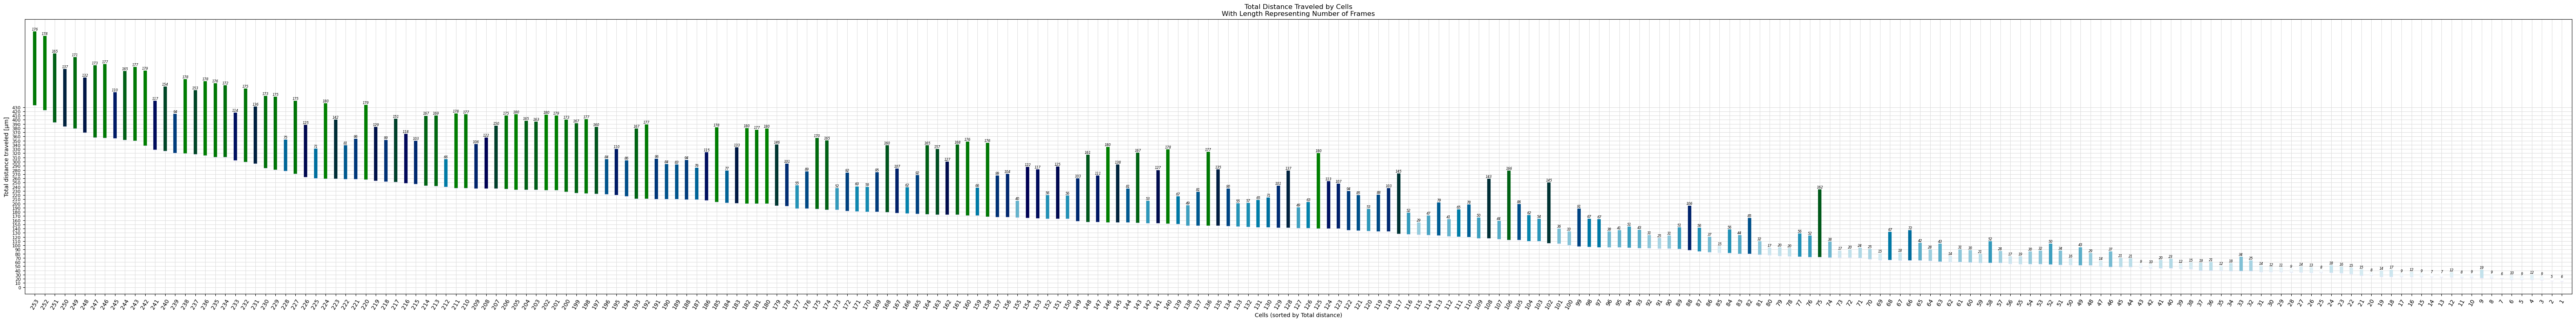

In [ ]:

def histogram_cells_distance(df, metric, str):
    
    # Sort the DataFrame by 'TRACK_LENGTH' in ascending order
    df_sorted = df.sort_values(by=metric)

    norm = mcolors.Normalize(vmin=df_sorted["NUM_FRAMES"].min(), vmax=df_sorted["NUM_FRAMES"].max())
    cmap = plt.colormaps["ocean_r"]

    # Create new artificial IDs for sorting purposes (1 for lowest distance, N for highest)
    df_sorted["Artificial_ID"] = range(1, len(df_sorted) + 1)

    x_span = PlotParams.x_span(df_sorted)

    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(x_span, 8))
    fig.set_tight_layout(True)
    width = 6

    # Loop through each row to plot each cell's data
    for idx, row in df_sorted.iterrows():
        artificial_id = row["Artificial_ID"]
        track_length = row[metric]
        num_frames = row["NUM_FRAMES"]

        # Get the color based on the number of frames using the viridis colormap
        line_color = cmap(norm(num_frames))

        # Plot the "chimney" or vertical line
        ax.vlines(
            x=artificial_id,  # X position for the cell
            ymin=track_length,  # Starting point of the line (y position)
            ymax=track_length + num_frames,  # End point based on number of frames (height)
            color=line_color,
            linewidth=width,
            )

        plt.plot(artificial_id, track_length, '_', zorder=5, color="lavender")

        # Add the mean number of frames as text above each chimney
        ax.text(
        artificial_id,  # X position (same as the chimney)
        track_length + num_frames + 1,  # Y position (slightly above the chimney)
        f"{round(num_frames)}",  # The text to display (formatted mean)
        ha='center',  # Horizontal alignment center
        va='bottom',  # Vertical alignment bottom
        fontsize=6,  # Adjust font size if necessary
        color='black',  # Color of the text
        style='italic'  # Italicize the text
        )

        x = int(row['Artificial_ID'])

        plt.xticks(range(x), rotation=90) # add loads of ticks
        plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
        plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)


    max_y = df_sorted[metric].max()
    num_x_values = df_sorted[metric].count()

    # Adjust the plot aesthetics
    plt.tick_params(axis='x', rotation=60)
    plt.tick_params(axis='y', labelsize=8)
    plt.xticks(range(num_x_values)) # add loads of ticks
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

    # Set ticks, labels and title
    ax.set_xticks(range(1, num_x_values + 1))
    ax.set_yticks(np.arange(0, max_y + 1, 10))
    ax.set_xlabel(f"Cells (sorted by {str} distance)")
    ax.set_ylabel(f"{str} distance traveled [μm]")
    ax.set_title(f"{str} Distance Traveled by Cells\nWith Length Representing Number of Frames")

    # Invert x-axis so the highest distance is on the left
    plt.gca().invert_xaxis()

    ax.set_xlim(right=0, left=num_x_values+1)  # Adjust the left limit as needed

    # Show the plot
    plt.savefig(op.join(save_path, f"02f_Histogram_{str}_distance_traveled_per_cell.png"))
    plt.show()
histogram_cells_distance(Track_stats, 'NET_DISTANCE', 'Net')
histogram_cells_distance(Track_stats, 'TRACK_LENGTH', 'Total')

---
*Histogram plotting percentile groups in the cell dataset - migrated distance together with the time window in which it has been imaged:*

&#x1F6A7; *under construction* &#x1F6A7; 

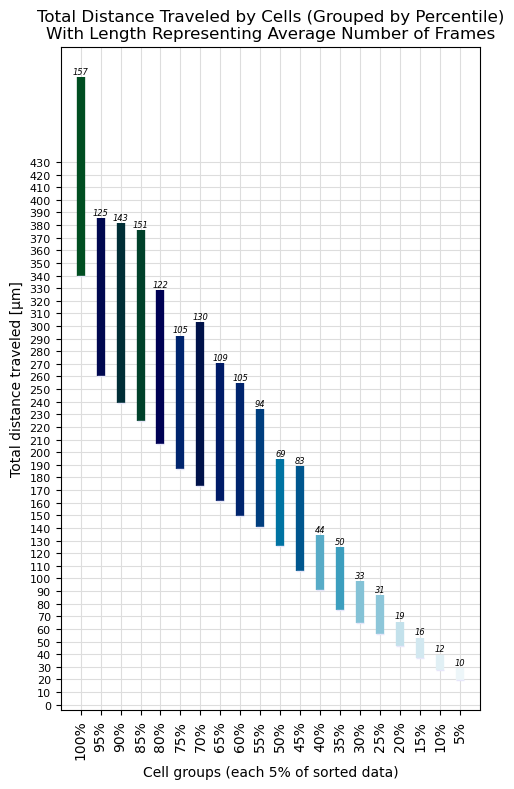

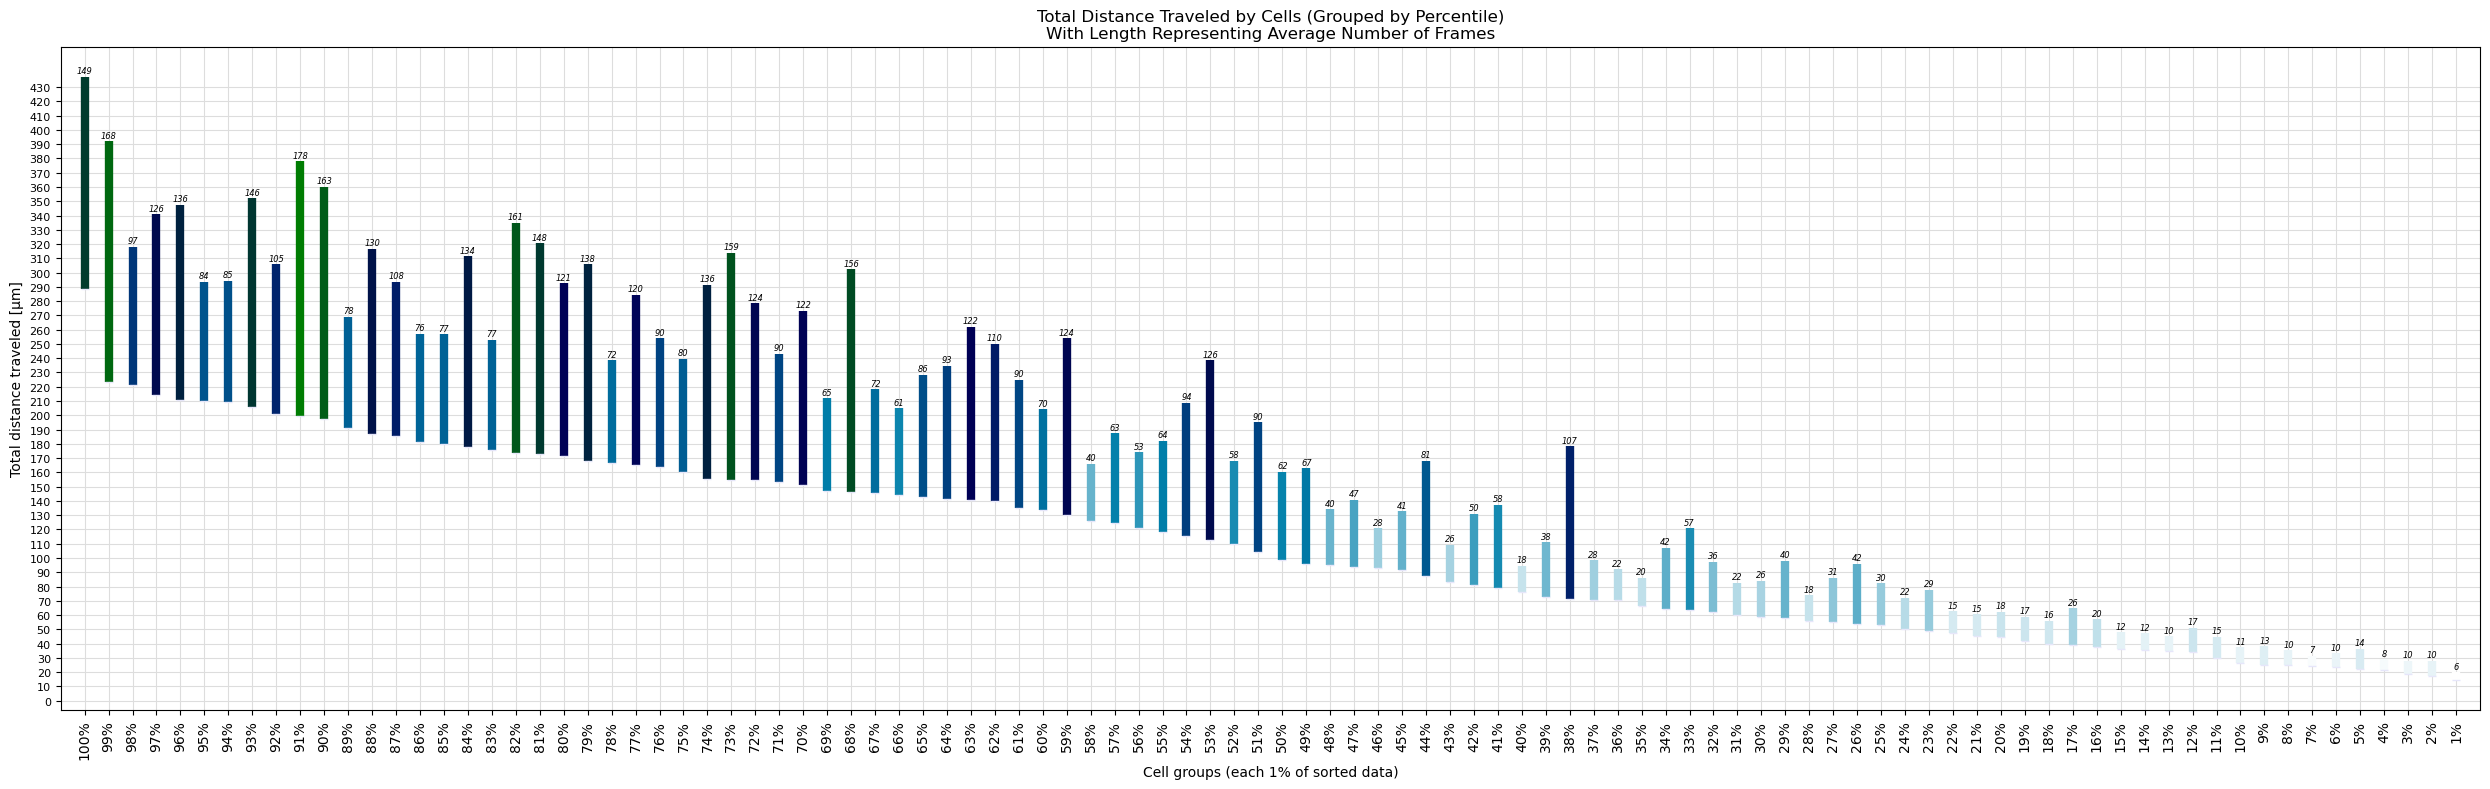

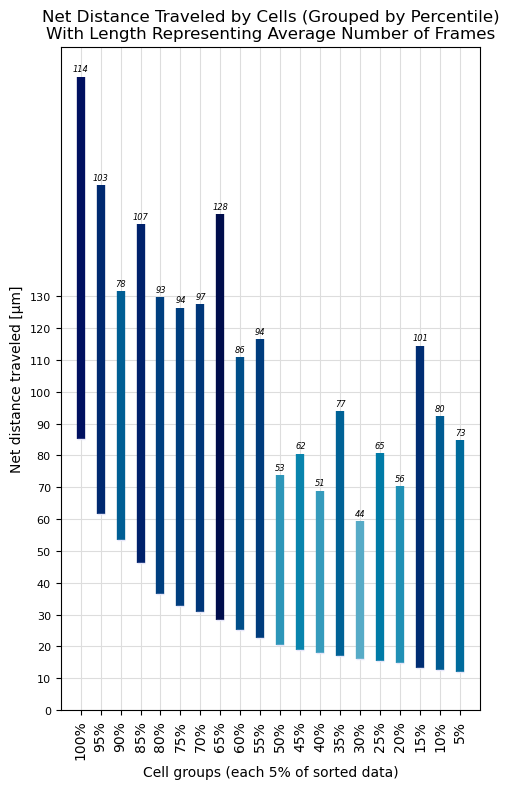

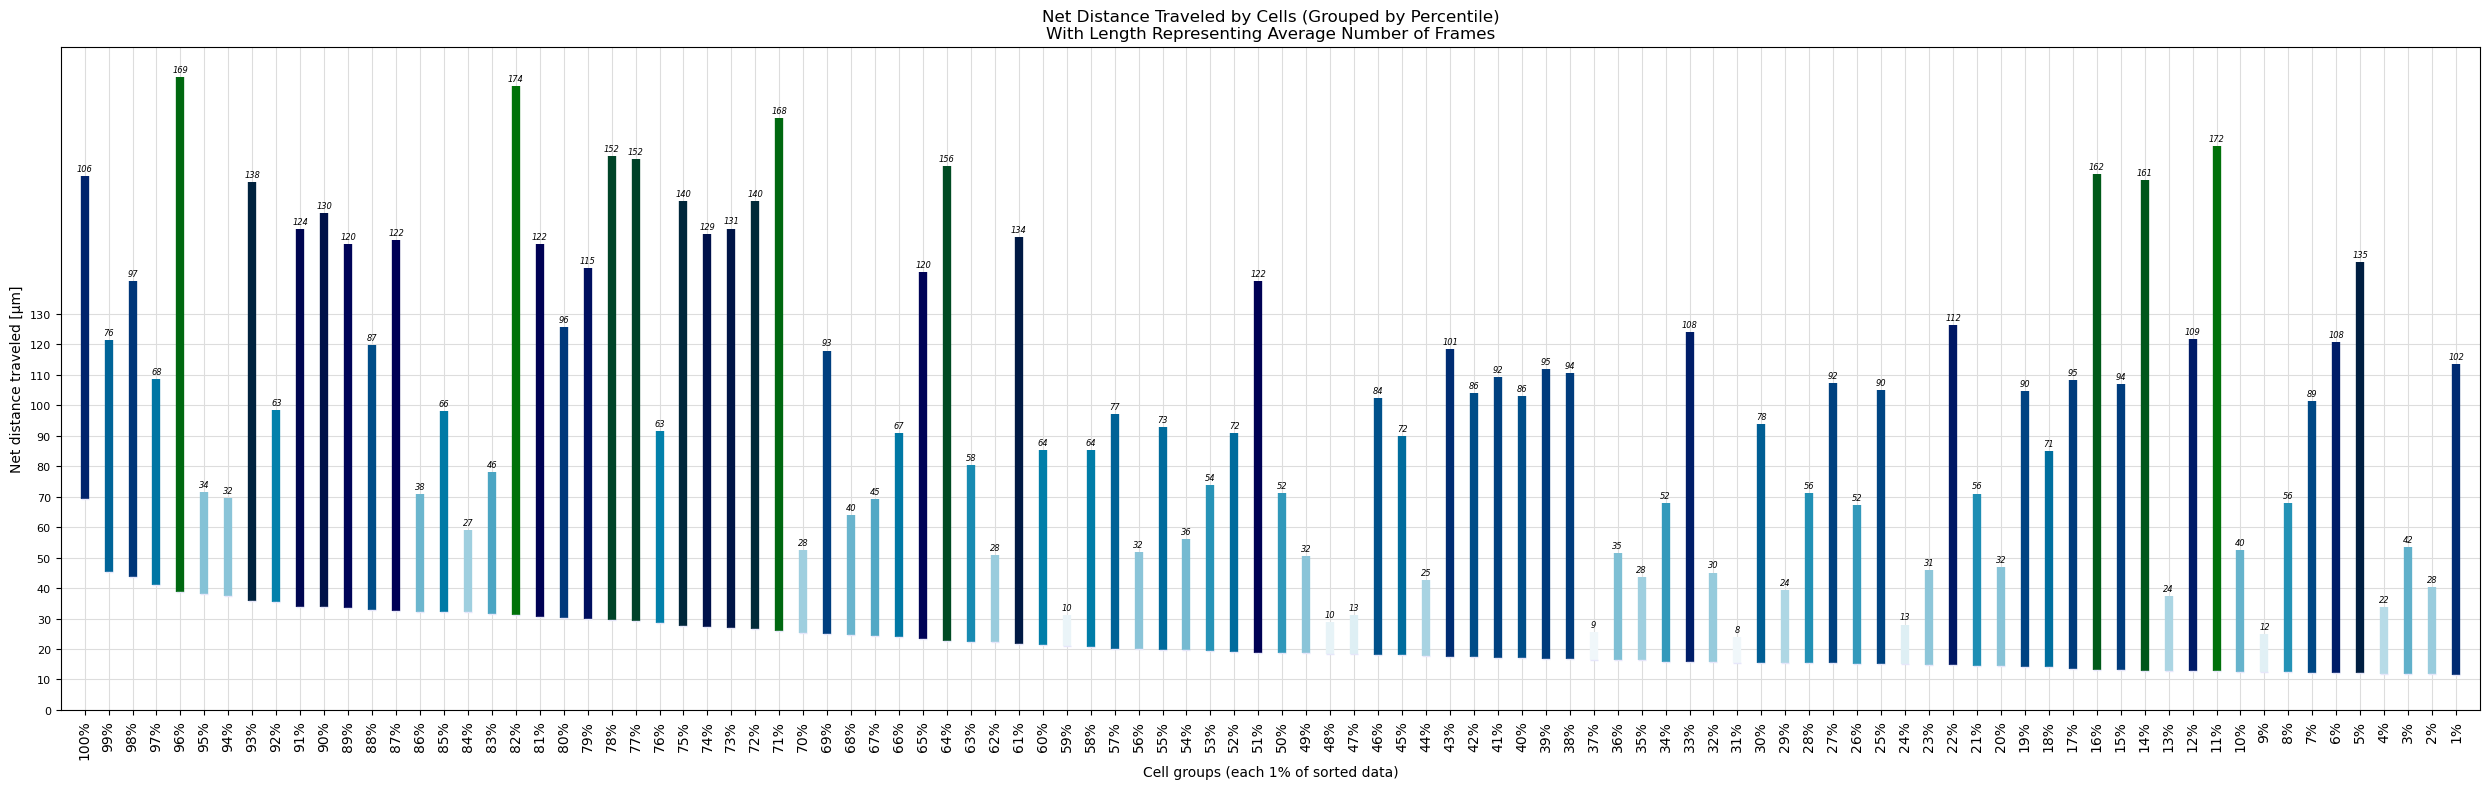

In [ ]:
def histogram_nth_percentile_distance(df, metric, num_groups, percentiles, str, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Sort the DataFrame by 'NET_DISTANCE' in ascending order
    df_sorted = df.sort_values(by=metric)

    # Number of groups (chimneys) and size of each group (5% each)
    group_size = len(df_sorted) // num_groups

    x_span = num_groups * 0.25

    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(x_span, 8))
    fig.set_tight_layout(True)
    width = 6

    # Normalize the 'NUM_FRAMES' column for color mapping
    norm = mcolors.Normalize(vmin=df_sorted["NUM_FRAMES"].min(), vmax=df_sorted["NUM_FRAMES"].max())
    cmap = plt.colormaps["ocean_r"]

    # Loop over each group and plot the aggregate statistics
    for i in range(num_groups):
        # Define group indices
        group_start = i * group_size
        group_end = (i + 1) * group_size if i != num_groups - 1 else len(df_sorted)

        # Get the current group data
        group_data = df_sorted.iloc[group_start:group_end]

        # Calculate the aggregate statistics for the group
        group_mean_distance = group_data[metric].mean()
        group_mean_frames = group_data["NUM_FRAMES"].mean()

        # Set x-position of the group (e.g., center it based on group index)
        group_x = i + 1

        # Get the color based on the average number of frames in the group
        line_color = cmap(norm(group_mean_frames))

        # Plot the "chimney" representing the group
        ax.vlines(
            x=group_x,  # X position for the group
            ymin=group_mean_distance,  # Starting point of the line (y position)
            ymax=group_mean_distance + group_mean_frames,  # End point based on average number of frames (height)
            color=line_color,
            linewidth=width,
            )

        plt.plot(group_x, group_mean_distance, '_', zorder=5, color="lavender")

        # Add the mean number of frames as text above each chimney
        ax.text(
            group_x,  # X position (same as the chimney)
            group_mean_distance + group_mean_frames + 1,  # Y position (slightly above the chimney)
            f'{round(group_mean_frames)}',  # The text to display (formatted mean)
            ha='center',  # Horizontal alignment center
            va='bottom',  # Vertical alignment bottom
            fontsize=6,  # Adjust font size if necessary
            color='black',  # Color of the text
            style='italic'
            )

    max_y = df_sorted[metric].max() 

    # Adjust the plot aesthetics
    plt.xticks(range(group_x)) # add loads of ticks
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

    plt.tick_params(axis='x', rotation=60)
    plt.tick_params(axis='y', labelsize=8) 

    ax.set_xticks(range(1, num_groups + 1))
    ax.set_xticklabels([f"{percentiles * (i + 1)}%" for i in range(num_groups)], rotation=90)
    ax.set_yticks(np.arange(0, max_y + 1, 10))
    ax.set_xlabel(f"Cell groups (each {percentiles}% of sorted data)")
    ax.set_ylabel(f"{str} distance traveled [μm]")
    ax.set_title(f"{str} Distance Traveled by Cells (Grouped by Percentile)\nWith Length Representing Average Number of Frames")
    ax.grid(which="major", color="#DDDDDD", linewidth=0.8)
    ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

    # Invert x-axis so the highest distance is on the left
    ax.invert_xaxis()

    ax.set_xlim(right=0, left=num_groups+1)  # Adjust the left limit as needed

    # Show the plot
    plt.savefig((op.join(save_path, f"02f_Histogram_{str}_distance_traveled_{percentiles}th_percentiles{threshold}.png")))
    plt.show()
histogram_nth_percentile_distance(Track_stats, 'TRACK_LENGTH', 20, 5, 'Total', None)
histogram_nth_percentile_distance(Track_stats, 'TRACK_LENGTH', 100, 1, 'Total', None)
histogram_nth_percentile_distance(Track_stats, 'NET_DISTANCE', 20, 5, 'Net', None)
histogram_nth_percentile_distance(Track_stats, 'NET_DISTANCE', 100, 1, 'Net', None)
# histogram_nth_percentile_distance(Track_stats_thresholded_at_20th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_20th_percentile') # 20th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_20th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_20th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_40th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_40th_percentile') # 40th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_40th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_40th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_60th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_60th_percentile') # 60th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_60th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_60th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_80th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_80th_percentile') # 80th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_80th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_80th_percentile')

---
*Histogram plotting the median and mean speed of migration per frame* &#x1F3D7;

&#x1F6A7; *under heavy construction* &#x1F6A7; 

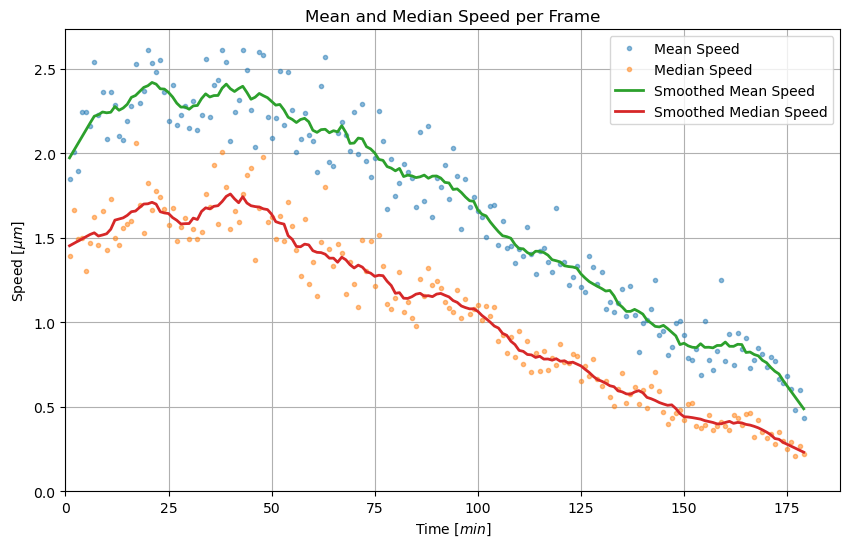

In [ ]:
frames = Frame_stats['POSITION_T'][1:-1]
mean_speed = Frame_stats['SPEED_MEAN'][1:-1]
median_speed = Frame_stats['SPEED_MEDIAN'][1:-1]

# Apply Savitzky-Golay filter for smoothing
mean_speed_smooth = savgol_filter(mean_speed, window_length=11, polyorder=1)
median_speed_smooth = savgol_filter(median_speed, window_length=11, polyorder=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frames, mean_speed, '.', label='Mean Speed', alpha=0.5)
plt.plot(frames, median_speed, '.', label='Median Speed', alpha=0.5)
plt.plot(frames, mean_speed_smooth, '-', label='Smoothed Mean Speed', linewidth=2)
plt.plot(frames, median_speed_smooth, '-', label='Smoothed Median Speed', linewidth=2)

# Set x-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.xlabel(r'Time $\it{[min]}$')
plt.ylabel(r'Speed $\it{[μm]}$')
plt.title('Mean and Median Speed per Frame')
plt.legend()
plt.grid(True)
plt.show()

---


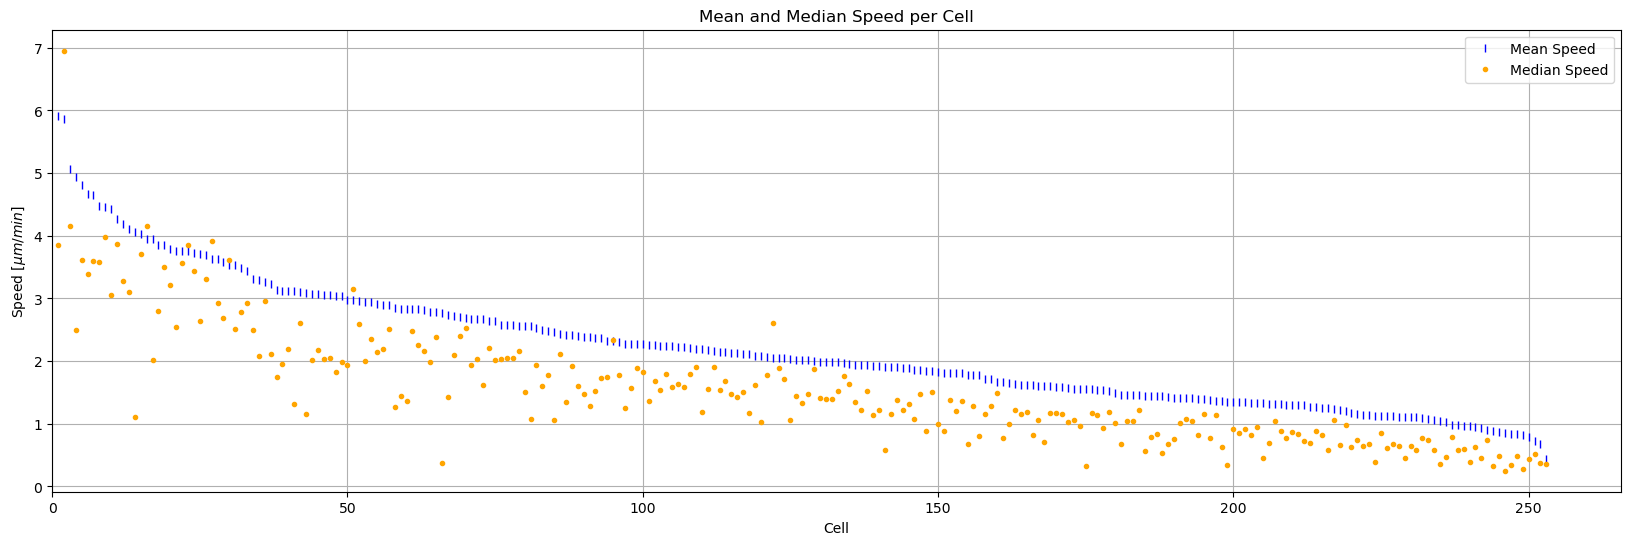

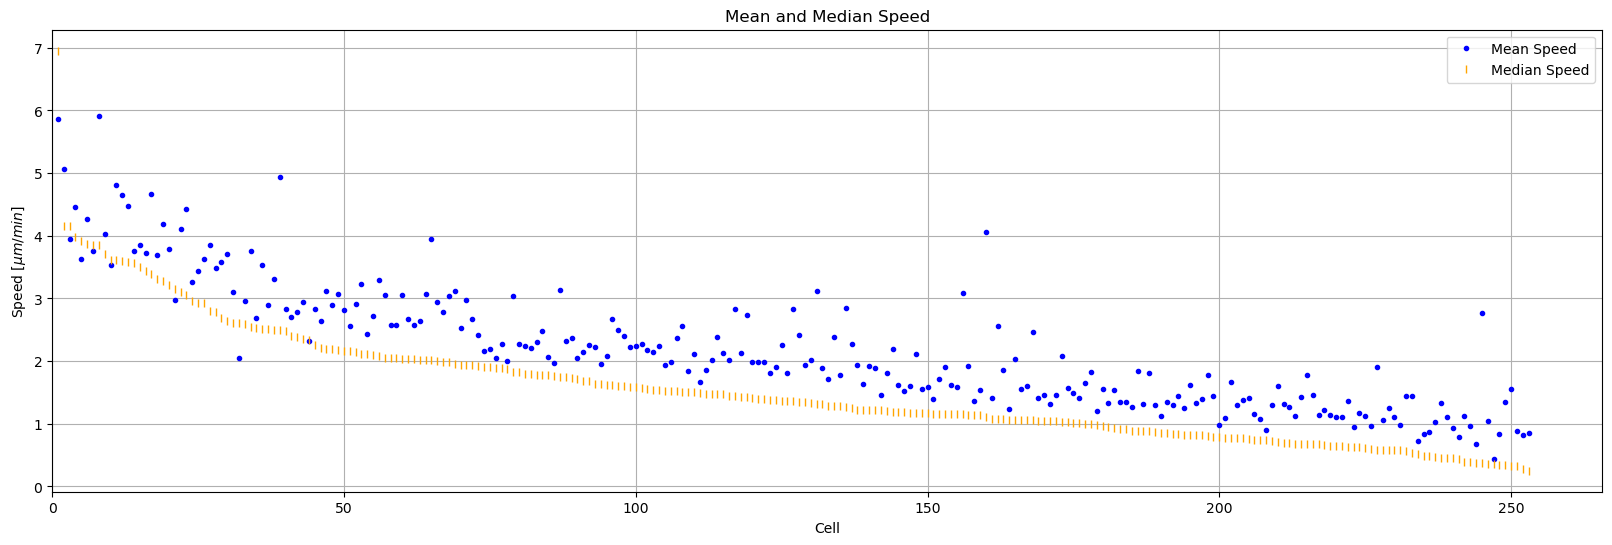

In [ ]:
# Sort the DataFrame by 'TRACK_LENGTH' in ascending order
df_sorted_a = Track_stats.sort_values(by='SPEED_MEAN', ascending=False)
df_sorted_b = Track_stats.sort_values(by='SPEED_MEDIAN', ascending=False)

# Create new artificial IDs for sorting purposes (1 for lowest distance, N for highest)
df_sorted_a["Artificial_ID"] = range(1, len(df_sorted_a) + 1)
df_sorted_b["Artificial_ID"] = range(1, len(df_sorted_b) + 1)

# defining variables
cell_id_a = df_sorted_a["Artificial_ID"]
mean_speed_a = df_sorted_a['SPEED_MEAN']
median_speed_a = df_sorted_a['SPEED_MEDIAN']

cell_id_b = df_sorted_b["Artificial_ID"]
mean_speed_b = df_sorted_b['SPEED_MEAN']
median_speed_b = df_sorted_b['SPEED_MEDIAN']

# mean_speed_smooth = savgol_filter(mean_speed_a, window_length=11, polyorder=1)
# median_speed_smooth = savgol_filter(median_speed_b, window_length=11, polyorder=1)



x_span = PlotParams.x_span(Track_stats4_df, 0.08)

# Plotting no. 1
plt.figure(figsize=(x_span, 6))
plt.plot(cell_id_a, mean_speed_a, '|', label='Mean Speed', color='blue')
plt.plot(cell_id_a, median_speed_a, '.', label='Median Speed', color='orange')
# plt.plot(cell_id_a, mean_speed_smooth, '-', label='Mean Speed', linewidth=2, color='blue', zorder=1)

# Set x-axis to start at 0
plt.xlim(left=0)

plt.xlabel('Cell')
plt.ylabel(r'Speed $\it{[μm/min]}$')
plt.title('Mean and Median Speed per Cell')
plt.legend()
plt.grid(True)
plt.show()


# Plotting no. 2
plt.figure(figsize=(20, 6))
plt.plot(cell_id_b, mean_speed_b, '.', label='Mean Speed', color='blue')
plt.plot(cell_id_b, median_speed_b, '|', label='Median Speed', color='orange')
# plt.plot(cell_id_b, median_speed_smooth, '-', label='Median Speed', linewidth=2, color='orange', zorder=1)

# Set x-axis to start at 0
plt.xlim(left=0)

plt.xlabel('Cell')
plt.ylabel(r'Speed $\it{[μm/min]}$')
plt.title('Mean and Median Speed')
plt.legend()
plt.grid(True)
plt.show()

---
### Plotting the direction of migration &#x1F3D7;
&#x1F6A7; *under construction* &#x1F6A7; 

<>:94: SyntaxWarning: invalid escape sequence '\i'
<>:94: SyntaxWarning: invalid escape sequence '\i'
C:\Users\modri\AppData\Local\Temp\ipykernel_13740\3041876227.py:94: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'Mean Direction of Travel with Kernel Density Estimate\n$\it{{{subject}}}$', fontsize=title_size)


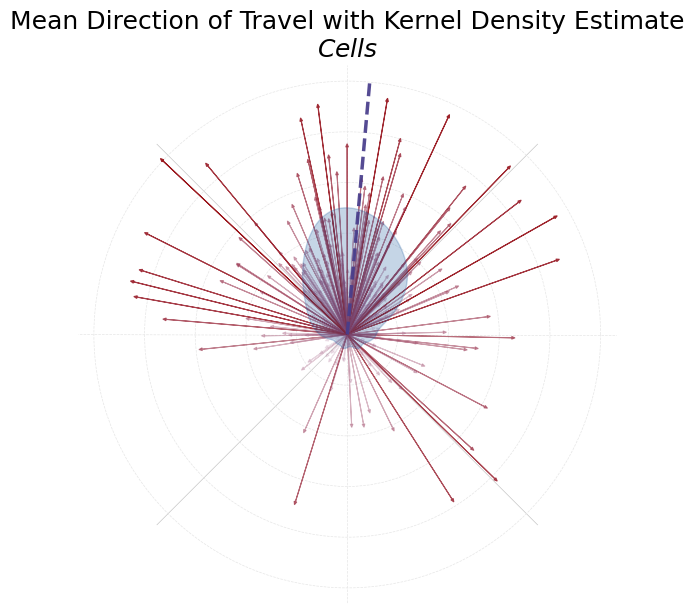

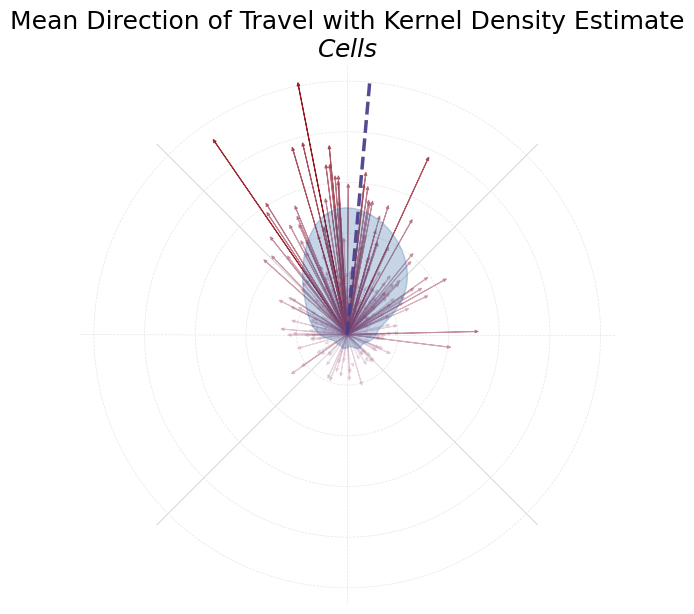

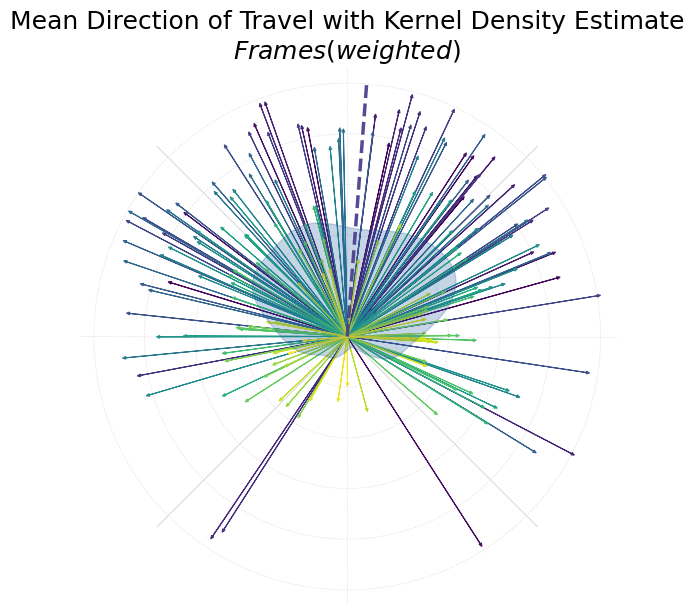

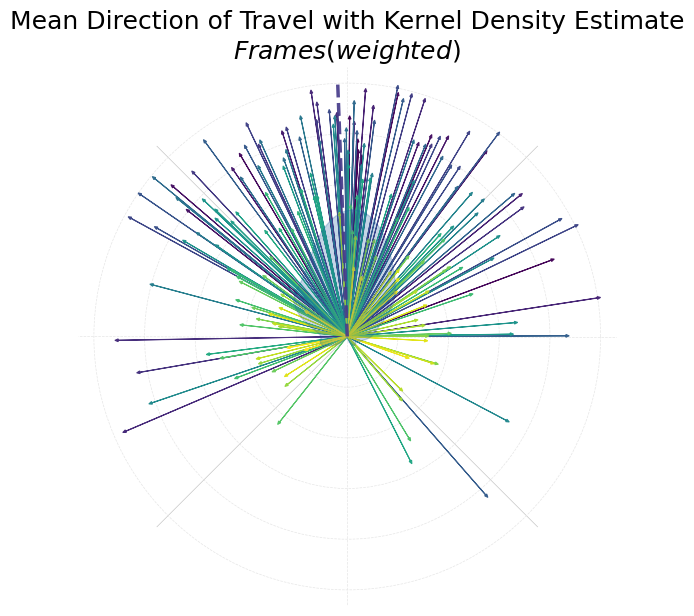

In [ ]:
cmap_cells = mcolors.LinearSegmentedColormap.from_list("", ["#9b598910", "#9b181eff"]) #303030
cmap_frames = plt.get_cmap('viridis')

def migration_directions_with_kde_plus_mean(df, metric, subject, scaling_metric, cmap_normalization_metric, cmap, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    df_mean_direction = df[metric]

    # Prepare for KDE plot
    x_kde = np.cos(df_mean_direction)
    y_kde = np.sin(df_mean_direction)
    kde = gaussian_kde([x_kde, y_kde])

    # Define the grid for evaluation
    theta_kde = np.linspace(0, 2 * np.pi, 360)
    x_grid = np.cos(theta_kde)
    y_grid = np.sin(theta_kde)

    # Evaluate the KDE on the grid and normalize
    z_kde = kde.evaluate([x_grid, y_grid])
    z_kde = z_kde / z_kde.max() * 0.5  # Normalize to fit within the radial limit

    # Calculate the mean direction
    mean_direction = np.arctan2(np.mean(y_kde), np.mean(x_kde))

    # Start plotting
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'polar': True})

    # Plot KDE
    ax.plot(theta_kde, z_kde, label='Circular KDE', color='None', zorder=5)
    ax.fill(theta_kde, z_kde, alpha=0.25, color='#1b5a9e', zorder=5)

    # Directional Arrows
    scaling_max = df[scaling_metric].max()

    # Normalization of the color map
    if cmap_normalization_metric == None:
        norm = mcolors.Normalize(vmin=0, vmax=1)
    else:
        normalization_min = df[cmap_normalization_metric].min()
        normalization_max = df[cmap_normalization_metric].max()
        norm = mcolors.Normalize(vmin=normalization_min, vmax=normalization_max)

    # Row itteration
    for _, row in df.iterrows():
        scaling_metrics = row[scaling_metric]
        mean_direction_rad = row[metric]
        arrow_length = scaling_metrics / scaling_max

        if cmap_normalization_metric == None:
            color = cmap(norm(arrow_length))
        else:
            color = cmap(norm(row[cmap_normalization_metric]))

        if arrow_length == 0:
            continue  # Skip if the arrow length is zero

        # Dynamically adjust the head size based on arrow_length
        scaling_factor = 1 / arrow_length if arrow_length != 0 else 1
        head_width = 0.011 * scaling_factor
        head_length = 0.013

        ax.arrow(mean_direction_rad, 0, 0, arrow_length, color=color, linewidth=0.75, 
                head_width=head_width, head_length=head_length, zorder=4)

    # Plot the dashed line in the mean direction
    ax.plot([mean_direction, mean_direction], [0, 1], linestyle='--', color='darkslateblue', alpha=0.93, linewidth=2.5, zorder=6)

    # Hide the polar plot frame (spines) but keep the grid visible
    ax.spines['polar'].set_visible(False)
    # Customize grid lines (if needed)
    ax.grid(True, 'major', color='#C6C6C6', linestyle='-', linewidth=0.5, zorder=0)

    # Access and customize the radial grid lines
    radial_lines = ax.get_xgridlines()
    for i, line in enumerate(radial_lines):
        if i % 2 == 0:  # Customize every other radial grid line
            line.set_linestyle('--')
            line.set_color('#E6E6E6')
            line.set_linewidth(0.5)

    radial_lines = ax.get_ygridlines()
    for i, line in enumerate(radial_lines):
        line.set_linestyle('--')
        line.set_color('#E6E6E6')
        line.set_linewidth(0.5)

    # Customize the appearance of the polar plot
    ax.set_title(f'Mean Direction of Travel with Kernel Density Estimate\n$\it{{{subject}}}$', fontsize=title_size)
    ax.set_yticklabels([])  # Remove radial labels
    ax.set_xticklabels([])  # Remove angular labels

    # Save the plot
    plt.savefig(op.join(save_path, f'02c_Plot_directions_of_travel_with_mean_and_kernel_density_estimate_{subject}_{scaling_metric}{threshold}.png'), dpi=500)
    # plt.show()
migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'CONFINEMENT_RATIO', None, cmap_cells, None)
migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'NET_DISTANCE', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_DEG_weight_confinement', 'Cells (weighted)', 'CONFINEMENT_RATIO', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_DEG_weight_confinement', 'Cells (weighted)', 'NET_DISTANCE', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_RAD_weight_net_dis', 'Cells (weighted)', 'CONFINEMENT_RATIO', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_DEG_weight_net_dis', 'Cells (weighted)', 'NET_DISTANCE', None, cmap_cells, None)
migration_directions_with_kde_plus_mean(Frame_stats, 'MEAN_DIRECTION_RAD', 'Frames (weighted)', 'MEAN_DISTANCE', 'POSITION_T', cmap_frames, None)
migration_directions_with_kde_plus_mean(Frame_stats, 'MEAN_DIRECTION_RAD_weight_mean_dis', 'Frames (weighted)', 'MEAN_DISTANCE', 'POSITION_T', cmap_frames, None) 

In [ ]:
def donut(df, ax, outer_radius, inner_radius, kde_bw):
    # Extend the data circularly to account for wrap-around at 0 and 2*pi
    extended_data = np.concatenate([df - 2 * np.pi, df, df + 2 * np.pi])

    # Create a grid of theta values (angles)
    theta_grid = np.linspace(0, 2 * np.pi, 360)  # 360 points over full circle
    
    # Create a grid of radii
    r_grid = np.linspace(inner_radius, outer_radius, 100)  # Radius from inner to outer edge
    
    # Compute KDE values for the extended data
    kde = gaussian_kde(extended_data, bw_method=kde_bw)
    kde_values = kde.evaluate(theta_grid)  # Evaluate KDE on the regular theta grid
    
    # Repeat KDE values across radii to create the heatmap data
    kde_values = np.tile(kde_values, (r_grid.size, 1))
    
    # Normalize KDE values for consistent color mapping
    norm = Normalize(vmin=kde_values.min(), vmax=kde_values.max())
    
    # Create the meshgrid for the polar plot
    theta_mesh, r_mesh = np.meshgrid(theta_grid, r_grid)
    
    # Remove polar grid lines and labels
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines['polar'].set_visible(False)  # Hide the outer frame

    return theta_mesh, r_mesh, kde_values, norm

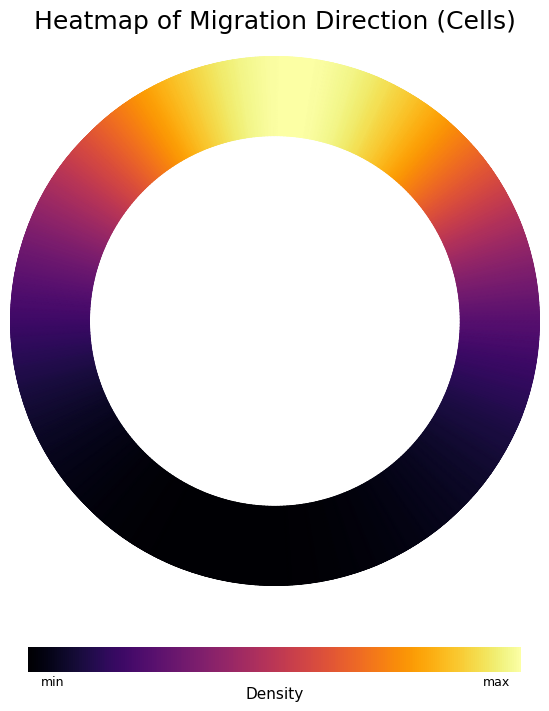

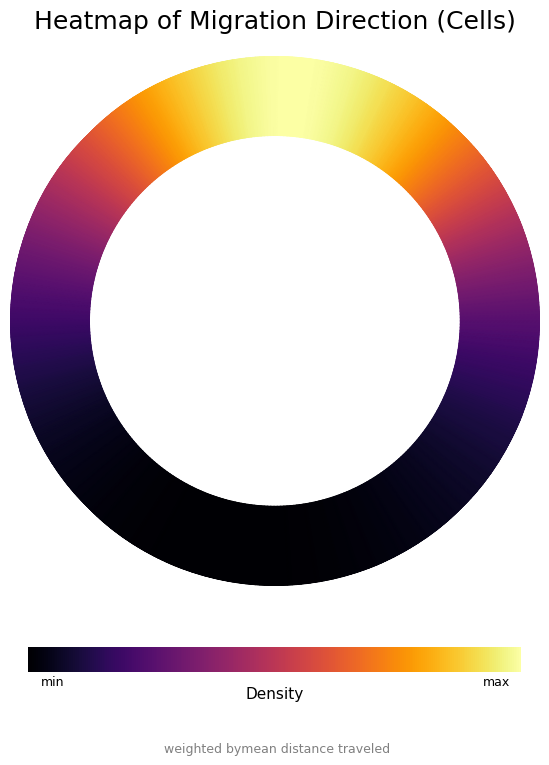

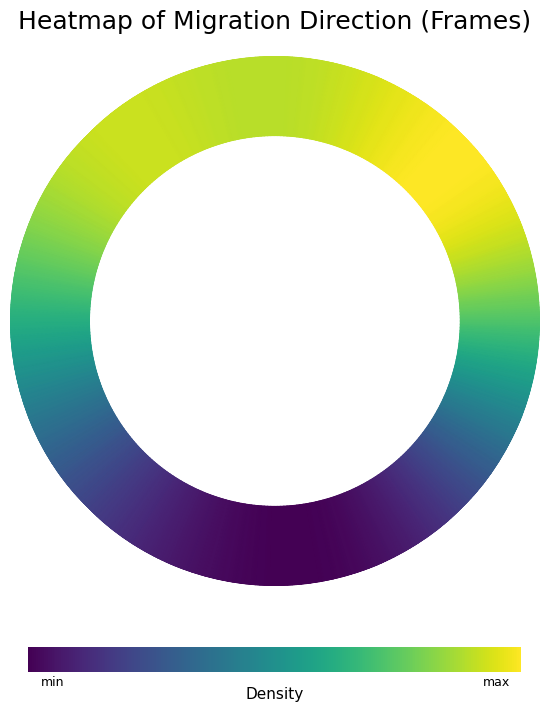

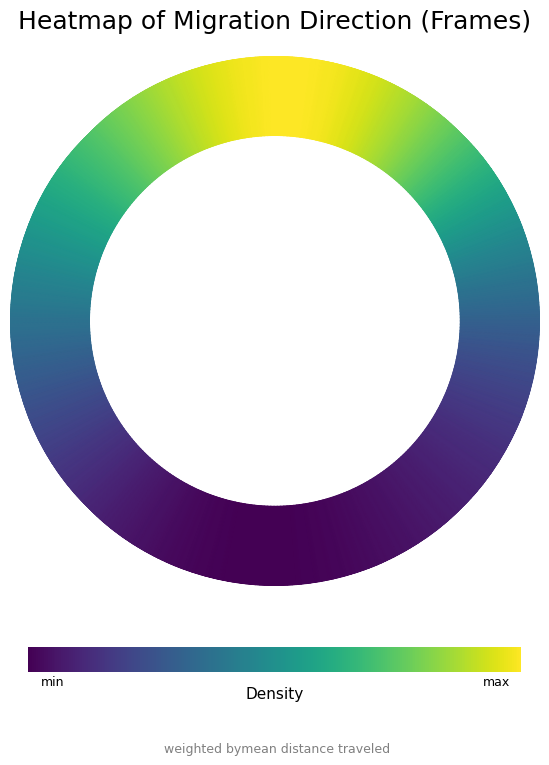

In [ ]:

def df_gaussian_donut(df, metric, subject, heatmap, weight, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    
    diameter=2
    width_ratio=0.3
    kde_bw=0.1

    df=df[metric]

    # Calculate radius and width from the diameter
    outer_radius = diameter / 2
    width = width_ratio * outer_radius
    inner_radius = outer_radius - width
    
    theta_mesh, r_mesh, kde_values, norm = donut(df, ax, outer_radius, inner_radius, kde_bw)
    
    # Set title and figure text
    ax.set_title(f'Heatmap of Migration Direction ({subject})', pad=20, ha='center', fontsize=title_size)
    
    # Add a colorbar
    cbar = plt.colorbar(ax.pcolormesh(theta_mesh, r_mesh, kde_values, shading='gouraud', cmap=heatmap, norm=norm), ax=ax, fraction=0.04, orientation='horizontal', pad=0.1)
    cbar.set_ticks([])
    cbar.outline.set_visible(False)  # Remove outline
    
    # Add min and max labels below the colorbar
    cbar.ax.text(0.05, -0.4, 'min', va='center', ha='center', color='black', transform=cbar.ax.transAxes, fontsize=9)
    cbar.ax.text(0.95, -0.4, 'max', va='center', ha='center', color='black', transform=cbar.ax.transAxes, fontsize=9)

    # Add the density label below the min and max labels
    cbar.set_label('Density', labelpad=10, fontsize=label_size)
    
    if weight == None:
        plt.savefig(op.join(save_path, f'04a_Plot_donut_heatmap-migration_direction_{subject}{threshold}.png'), dpi=300)
    else:
        weight = 'weighted by' + weight
        plt.figtext(0.515, 0.01, f'{weight}', ha='center', color=figtext_color, fontsize=figtext_size)
        plt.savefig(op.join(save_path, f'04a_Plot_donut_heatmap-migration_direction_{subject}{weight}{threshold}.png'), dpi=300)

    # plt.show()
df_gaussian_donut(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', None, None)
df_gaussian_donut(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'mean distance traveled', None)
# df_gaussian_donut(Track_stats_thresholded_at_20th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_20th_percentile') # 20th
# df_gaussian_donut(Track_stats_thresholded_at_40th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_40th_percentile') # 40th
# df_gaussian_donut(Track_stats_thresholded_at_60th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_60th_percentile') # 60th
# df_gaussian_donut(Track_stats_thresholded_at_80th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_80th_percentile') # 80th
# df_gaussian_donut(Track_stats_thresholded_at_90th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_90th_percentile') # 90th
df_gaussian_donut(Frame_stats, 'MEAN_DIRECTION_RAD', 'Frames', 'viridis', None, None)
df_gaussian_donut(Frame_stats, 'MEAN_DIRECTION_RAD_weight_mean_dis', 'Frames', 'viridis', 'mean distance traveled', None)


---
# *To try* / *To do* List

<ul>
    <li><input type="checkbox"> Weight Mean direction of travel in Time_Stats also by the NET_DISTANCE, making the dataset contain two columns for the weighted mean direction; by confinement ratio as well as net distance </li>

</ul>
